# 🧠 FASE 2 — ANÁLISIS EXPLORATORIO DE DATOS (EDA)

**Objetivo:** Entender la calidad de los datos, su distribución, sesgos y patrones básicos, tanto en imágenes como en datos clínicos.

---

## Estructura del Notebook

1. **EDA de Imágenes** (Validar H1: ¿Las imágenes contienen patrones distinguibles?)
2. **EDA de Datos Clínicos** (Validar H2: Los datos clínicos predicen deterioro cognitivo)
3. **Conclusiones del EDA**


In [20]:
import os
import sys
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from glob import glob
import random
from scipy import stats
from sklearn.preprocessing import StandardScaler
from PIL import Image
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Configuración de rutas
BASE_DIR = Path().resolve().parent
RAW_IMAGES_DIR = BASE_DIR / "data" / "raw" / "images"
RAW_CLINICAL_DIR = BASE_DIR / "data" / "raw" / "clinical"
PROCESSED_DIR = BASE_DIR / "data" / "processed"

print(f"📁 Directorio base: {BASE_DIR}")
print(f"📁 Imágenes raw: {RAW_IMAGES_DIR}")
print(f"📁 Datos clínicos: {RAW_CLINICAL_DIR}")


📁 Directorio base: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria
📁 Imágenes raw: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\raw\images
📁 Datos clínicos: C:\Users\mmera\OneDrive\Escritorio\ProyectoMineria\proyectoMineria\data\raw\clinical


---
# 🔵 2.1. EDA DE IMÁGENES

**Objetivo:** Validar H1 - ¿Las imágenes contienen patrones distinguibles?

## 📌 2.1.1. Cantidad de Imágenes por Clase


In [21]:
# Verificar qué datasets tenemos disponibles
print("📂 Datasets disponibles:")
if (RAW_IMAGES_DIR / "OriginalDataset").exists():
    print("  ✓ OriginalDataset")
if (RAW_IMAGES_DIR / "AugmentedAlzheimerDataset").exists():
    print("  ✓ AugmentedAlzheimerDataset")

# Usar el dataset original para el EDA (más representativo del dataset real)
dataset_name = "OriginalDataset"
if not (RAW_IMAGES_DIR / dataset_name).exists():
    dataset_name = "AugmentedAlzheimerDataset"

base_path = RAW_IMAGES_DIR / dataset_name
print(f"\n📊 Analizando: {dataset_name}")


📂 Datasets disponibles:
  ✓ OriginalDataset
  ✓ AugmentedAlzheimerDataset

📊 Analizando: OriginalDataset


In [22]:
# Contar imágenes por clase
classes = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented']
class_counts = {}
class_paths = {}

print("\n📊 Conteo de imágenes por clase:")
print("-" * 50)

for cls in classes:
    class_dir = base_path / cls
    if class_dir.exists():
        # Contar archivos JPG (buscar también .JPG en mayúsculas)
        image_files_jpg = list(class_dir.glob('*.jpg'))
        image_files_JPG = list(class_dir.glob('*.JPG'))
        image_files = image_files_jpg + image_files_JPG
        
        # Convertir a rutas absolutas para evitar problemas
        image_files = [Path(img).resolve() for img in image_files]
        
        count = len(image_files)
        class_counts[cls] = count
        class_paths[cls] = image_files
        print(f"{cls:20s}: {count:5d} imágenes")
        
        # Verificar que al menos una imagen existe realmente
        if count > 0:
            test_path = image_files[0]
            if not test_path.exists():
                print(f"  ⚠️  Advertencia: Primera imagen no existe: {test_path}")
    else:
        class_counts[cls] = 0
        class_paths[cls] = []
        print(f"{cls:20s}: 0 imágenes (directorio no encontrado)")

total_images = sum(class_counts.values())
print("-" * 50)
print(f"{'TOTAL':20s}: {total_images:5d} imágenes")



📊 Conteo de imágenes por clase:
--------------------------------------------------
NonDemented         :  6400 imágenes
VeryMildDemented    :  4480 imágenes
MildDemented        :  1792 imágenes
ModerateDemented    :   128 imágenes
--------------------------------------------------
TOTAL               : 12800 imágenes


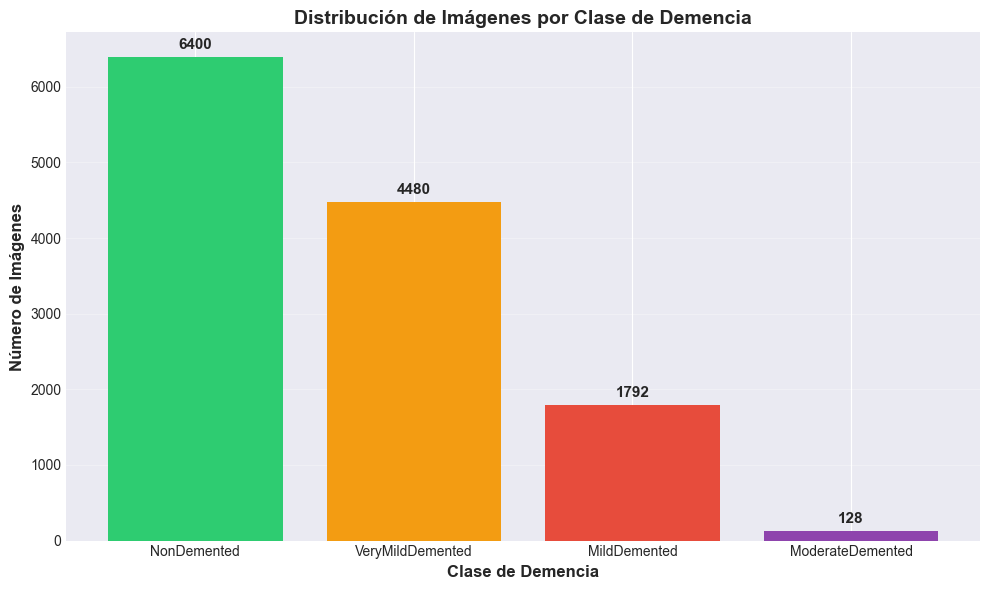


📈 Porcentajes por clase:
  NonDemented         : 50.00%
  VeryMildDemented    : 35.00%
  MildDemented        : 14.00%
  ModerateDemented    :  1.00%


In [23]:
# Gráfica: Barplot de número de imágenes por clase
fig, ax = plt.subplots(figsize=(10, 6))

classes_sorted = sorted(class_counts.keys(), key=lambda x: class_counts[x], reverse=True)
counts_sorted = [class_counts[cls] for cls in classes_sorted]
colors = ['#2ecc71', '#f39c12', '#e74c3c', '#8e44ad']

bars = ax.bar(classes_sorted, counts_sorted, color=colors[:len(classes_sorted)])

# Agregar valores en las barras
for i, (cls, count) in enumerate(zip(classes_sorted, counts_sorted)):
    ax.text(i, count + max(counts_sorted) * 0.01, str(count), 
            ha='center', va='bottom', fontweight='bold', fontsize=11)

ax.set_xlabel('Clase de Demencia', fontsize=12, fontweight='bold')
ax.set_ylabel('Número de Imágenes', fontsize=12, fontweight='bold')
ax.set_title('Distribución de Imágenes por Clase de Demencia', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Calcular porcentajes
print("\n📈 Porcentajes por clase:")
for cls in classes_sorted:
    pct = (class_counts[cls] / total_images) * 100
    print(f"  {cls:20s}: {pct:5.2f}%")


### 🔍 Interpretación del Desbalance

**Observaciones:**
- Hay un desbalance significativo
- Es común tener pocos casos de "ModerateDemented"
- TODO: Considerar técnicas de balanceo (oversampling, undersampling, class weights) para el entrenamiento

In [24]:
# Diagnóstico: Verificar que las rutas de imágenes son correctas
print("\n🔍 Diagnóstico de rutas de imágenes:")
print("=" * 70)

for cls in classes:
    if class_paths[cls] and len(class_paths[cls]) > 0:
        # Verificar primeras 3 imágenes
        sample_paths = class_paths[cls][:3]
        print(f"\n{cls}:")
        for idx, img_path in enumerate(sample_paths):
            path_str = str(img_path) if isinstance(img_path, Path) else str(img_path)
            exists = Path(path_str).exists()
            status = "✅" if exists else "❌"
            print(f"  {status} [{idx+1}] {Path(path_str).name[:50]}")
            if not exists:
                print(f"     Ruta completa: {path_str[:80]}")
    else:
        print(f"\n{cls}: ❌ No hay imágenes en esta clase")



🔍 Diagnóstico de rutas de imágenes:

NonDemented:
  ✅ [1] 26 (100).jpg
  ✅ [2] 26 (62).jpg
  ✅ [3] 26 (63).jpg

VeryMildDemented:
  ✅ [1] 26 (44).jpg
  ✅ [2] 26 (45).jpg
  ✅ [3] 26 (46).jpg

MildDemented:
  ✅ [1] 26 (19).jpg
  ✅ [2] 26 (20).jpg
  ✅ [3] 26 (21).jpg

ModerateDemented:
  ✅ [1] 27 (2).jpg
  ✅ [2] 27.jpg
  ✅ [3] 28 (2).jpg


## 📌 2.1.2. Histogramas de Intensidad

In [25]:
def plot_intensity_histogram(image_path, ax, title):
    """Grafica el histograma de intensidades de una imagen."""
    try:
        # Convertir a Path si es necesario y luego a string
        if isinstance(image_path, Path):
            img_path_str = str(image_path)
        else:
            img_path_str = str(image_path)
        
        # Verificar que el archivo existe
        if not Path(img_path_str).exists():
            ax.text(0.5, 0.5, f'Archivo no existe', ha='center', va='center', fontsize=9)
            return
        
        # Leer imagen con PIL y convertir a escala de grises
        img = Image.open(img_path_str).convert('L')  # 'L' = escala de grises
        img_array = np.array(img)
        
        if img_array.size == 0:
            ax.text(0.5, 0.5, 'Imagen vacía', ha='center', va='center', fontsize=9)
            return
        
        # Si llegamos aquí, img_array está definido y es válido - generar el histograma
        ax.hist(img_array.ravel(), bins=256, range=(0, 256), alpha=0.7, color='steelblue', edgecolor='black')
        ax.set_xlabel('Intensidad de Píxel', fontsize=10)
        ax.set_ylabel('Frecuencia', fontsize=10)
        ax.set_title(title, fontsize=11, fontweight='bold')
        ax.grid(alpha=0.3)
        
        # Estadísticas
        mean_intensity = img_array.mean()
        std_intensity = img_array.std()
        ax.axvline(mean_intensity, color='red', linestyle='--', linewidth=2, label=f'Media: {mean_intensity:.1f}')
        ax.legend(fontsize=9)
        
    except Exception as e:
        error_msg = str(e)[:50]  # Limitar longitud del mensaje
        ax.text(0.5, 0.5, f'Error: {error_msg}', ha='center', va='center', fontsize=8, wrap=True)
        return
    
    
    # Estadísticas



📸 Procesando NonDemented: 3 imágenes

📸 Procesando VeryMildDemented: 3 imágenes

📸 Procesando MildDemented: 3 imágenes

📸 Procesando ModerateDemented: 3 imágenes


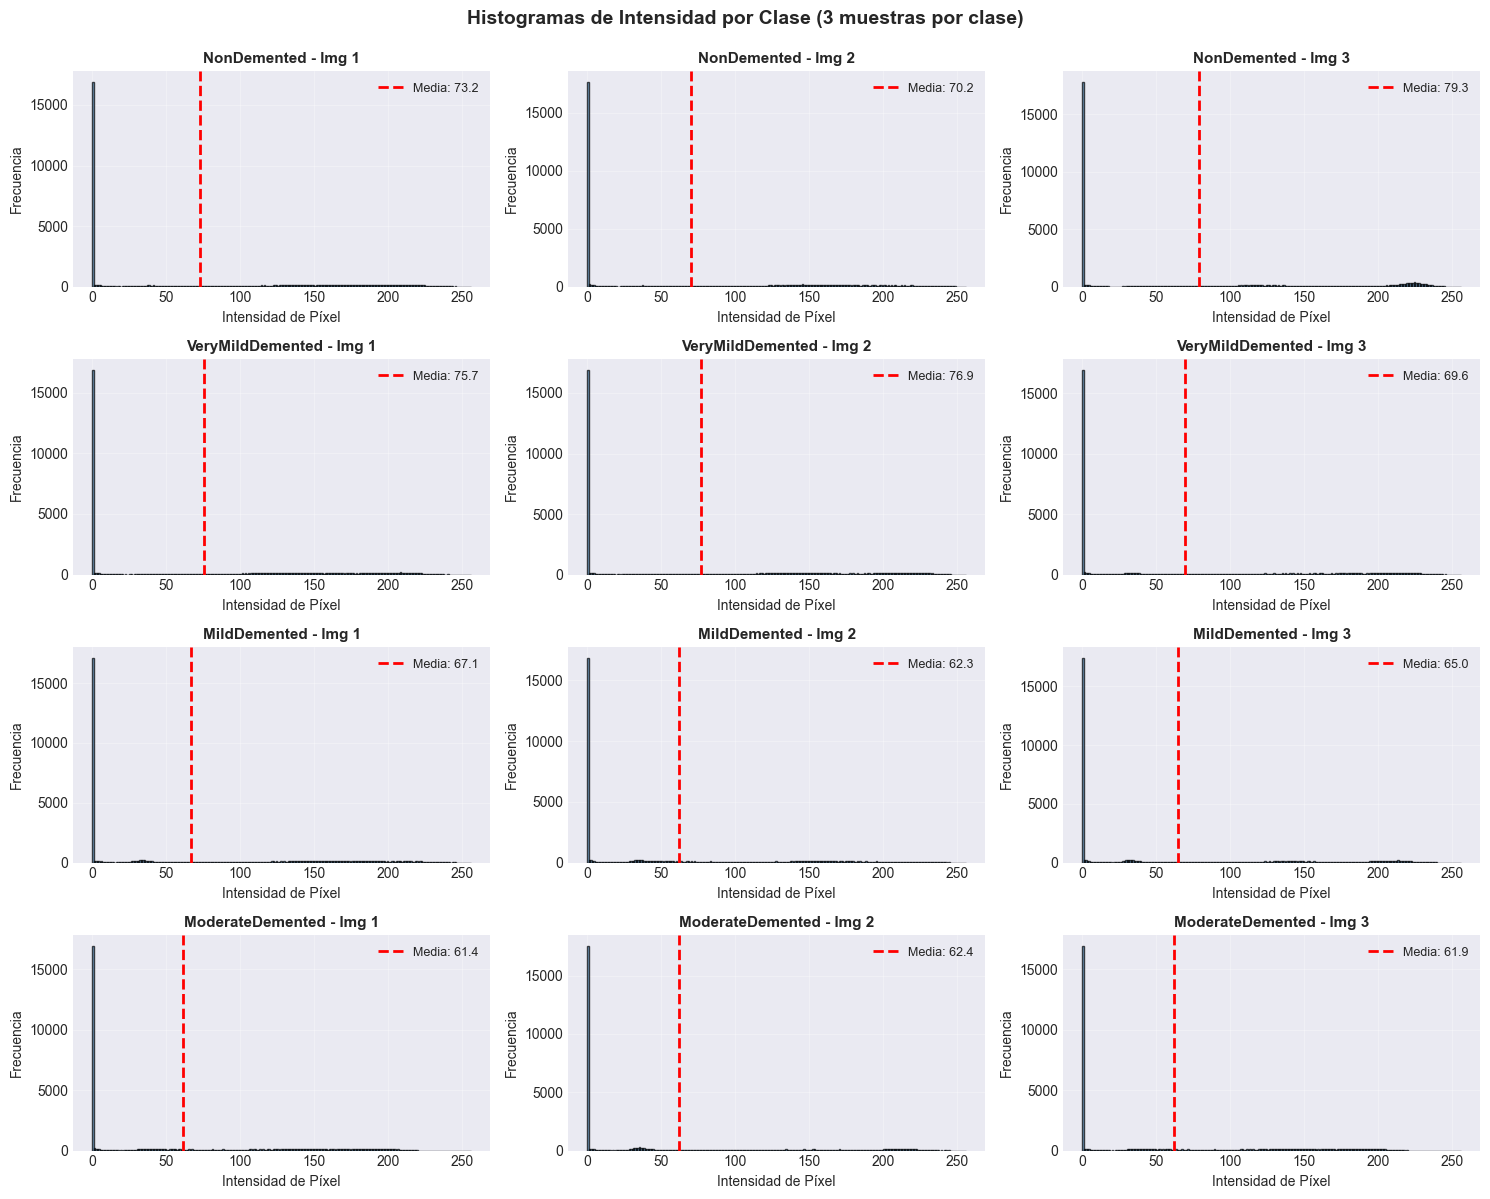

In [26]:
# Seleccionar 3-5 imágenes aleatorias por clase para análisis
samples_per_class = 3
fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(15, 12))

if len(axes.shape) == 1:
    axes = axes.reshape(-1, 1)

for i, cls in enumerate(classes):
    if class_paths[cls] and len(class_paths[cls]) > 0:
        # Seleccionar muestras aleatorias
        n_samples = min(samples_per_class, len(class_paths[cls]))
        samples = random.sample(class_paths[cls], n_samples)
        
        print(f"\n📸 Procesando {cls}: {n_samples} imágenes")
        for j, img_path in enumerate(samples):
            # Verificar que el path existe antes de procesar
            if isinstance(img_path, Path):
                path_str = str(img_path)
            else:
                path_str = str(img_path)
            
            if Path(path_str).exists():
                plot_intensity_histogram(img_path, axes[i, j], f"{cls} - Img {j+1}")
            else:
                axes[i, j].text(0.5, 0.5, f'No existe:\n{Path(path_str).name}', 
                              ha='center', va='center', fontsize=8)
                axes[i, j].set_title(f"{cls} - Error", fontsize=10)
    else:
        for j in range(samples_per_class):
            axes[i, j].text(0.5, 0.5, 'No hay imágenes', ha='center', va='center')
            axes[i, j].set_title(f"{cls} - Sin datos")

plt.suptitle('Histogramas de Intensidad por Clase (3 muestras por clase)', 
             fontsize=14, fontweight='bold', y=0.995)
plt.tight_layout()
plt.show()


In [33]:
# Análisis estadístico de intensidades por clase
from scipy.optimize import root


print("\n📊 Estadísticas de Intensidad por Clase:")
print("-" * 70)

intensity_stats = {}

for cls in classes:
    if class_paths[cls]:
        # Muestrear 50 imágenes por clase para el análisis
        sample_size = min(50, len(class_paths[cls]))
        sample_images = random.sample(class_paths[cls], sample_size)
        
        intensities = []
        for img_path in sample_images:
            try:
                # Convertir path a string si es necesario
                path_str = str(img_path) if isinstance(img_path, Path) else str(img_path)
                
                # Verificar que existe
                if not Path(path_str).exists():
                    continue
                
                img = Image.open(path_str).convert('L')  # Convertir a escala de grises
                img_array = np.array(img)
                
                if img_array.size > 0:
                    intensities.extend(img_array.ravel())
            except Exception as e:
                # Continuar con la siguiente imagen si hay error
                continue
        
        if intensities:
            mean_int = np.mean(intensities)
            std_int = np.std(intensities)
            median_int = np.median(intensities)
            intensity_stats[cls] = {
                'mean': mean_int,
                'std': std_int,
                'median': median_int
            }
            print(f"{cls:20s}: Media={mean_int:6.2f}, Std={std_int:6.2f}, Mediana={median_int:6.2f}")

print("-" * 70)



📊 Estadísticas de Intensidad por Clase:
----------------------------------------------------------------------
NonDemented         : Media= 72.49, Std= 83.82, Mediana= 24.00
VeryMildDemented    : Media= 70.47, Std= 83.39, Mediana= 10.00
MildDemented        : Media= 68.10, Std= 80.70, Mediana= 21.00
ModerateDemented    : Media= 69.41, Std= 82.82, Mediana= 18.00
----------------------------------------------------------------------


### 🔍 Hallazgos:

- **Intensidades bajas** → Imágenes oscuras, posible necesidad de normalización
- **Intensidades altas** → Riesgo de saturación
- **Distribuciones distintas por clase** → Pueden sugerir patrones anatómicos diferenciados
- **TODO** Cuidar la desviación estándar entre imágenes de la misma categoría (normalización)


## 📌 2.1.3. Galería Visual por Clase

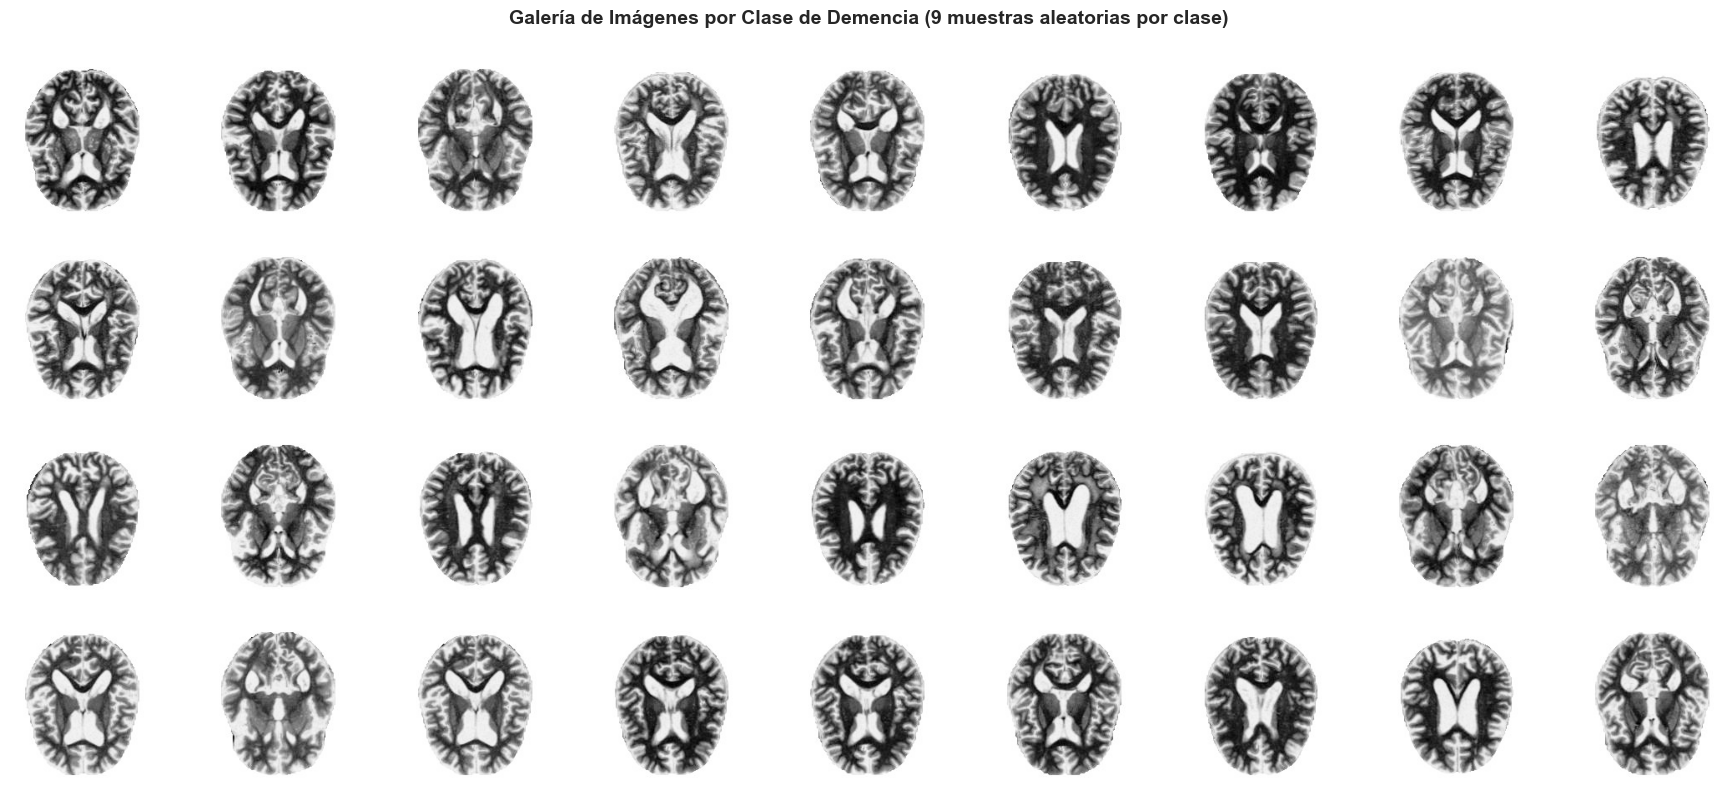

In [34]:
def plot_image_gallery(class_paths_dict, samples_per_class=9):
    """Crea una galería de imágenes por clase."""
    fig, axes = plt.subplots(len(classes), samples_per_class, figsize=(18, 8))
    
    if len(axes.shape) == 1:
        axes = axes.reshape(-1, 1)
    
    for i, cls in enumerate(classes):
        if class_paths_dict[cls]:
            # Seleccionar muestras aleatorias
            n_samples = min(samples_per_class, len(class_paths_dict[cls]))
            samples = random.sample(class_paths_dict[cls], n_samples)
            
            for j, img_path in enumerate(samples):
                try:
                    # Convertir path a string si es necesario
                    path_str = str(img_path) if isinstance(img_path, Path) else str(img_path)
                    
                    # Verificar que existe
                    if not Path(path_str).exists():
                        axes[i, j].text(0.5, 0.5, 'No existe', ha='center', va='center', fontsize=9)
                        axes[i, j].axis('off')
                        continue
                    
                    img = Image.open(path_str)
                    # PIL ya carga en RGB, no necesita conversión
                    axes[i, j].imshow(img)
                    axes[i, j].axis('off')
                    if j == 0:
                        axes[i, j].set_ylabel(cls, fontsize=12, fontweight='bold', rotation=0, ha='right', va='center')
                except Exception as e:
                    error_msg = str(e)[:30]  # Limitar longitud
                    axes[i, j].text(0.5, 0.5, f'Error:\n{error_msg}', ha='center', va='center', fontsize=8)
                    axes[i, j].axis('off')
            
            # Ocultar ejes vacíos
            for j in range(n_samples, samples_per_class):
                axes[i, j].axis('off')
        else:
            for j in range(samples_per_class):
                axes[i, j].text(0.5, 0.5, 'No hay imágenes', ha='center', va='center')
                axes[i, j].axis('off')
    
    plt.suptitle('Galería de Imágenes por Clase de Demencia (9 muestras aleatorias por clase)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()

# Crear galería
plot_image_gallery(class_paths, samples_per_class=9)


### 🔍 Observaciones sobre Calidad de Imágenes

**Qué observar:**
- [ ] **Ruido**: Presencia de artefactos o ruido en las imágenes
- [ ] **Artefactos**: Marcas, sombras o distorsiones
- [ ] **Orientación**: Consistencia en la orientación (sagital, axial, coronal)
- [ ] **Recortes**: Imágenes mal recortadas o con información faltante
- [ ] **Contraste**: Variaciones en el contraste entre imágenes
- [ ] **Diferencias visuales**: Notar si hay diferencias visuales evidentes entre clases

**Si algo está muy inconsistente** → Corregir en preprocesamiento


---
# 🔵 2.2. EDA DE DATOS CLÍNICOS

**Objetivo:** Validar H2 - Los datos clínicos predicen deterioro cognitivo

## 📌 2.2.1. Carga y Exploración Inicial


In [35]:
# Cargar datos clínicos
clinical_file = RAW_CLINICAL_DIR / "alzheimers_disease_data.csv"

if clinical_file.exists():
    df = pd.read_csv(clinical_file)
    print(f"✅ Datos cargados exitosamente")
    print(f"📊 Dimensiones: {df.shape[0]} filas × {df.shape[1]} columnas")
    print(f"\n📋 Primeras columnas:")
    print(df.columns.tolist()[:10])
else:
    print(f"❌ Archivo no encontrado: {clinical_file}")
    df = None


✅ Datos cargados exitosamente
📊 Dimensiones: 2149 filas × 35 columnas

📋 Primeras columnas:
['PatientID', 'Age', 'Gender', 'Ethnicity', 'EducationLevel', 'BMI', 'Smoking', 'AlcoholConsumption', 'PhysicalActivity', 'DietQuality']


In [36]:
if df is not None:
    # Información general del dataset
    print("\n📊 Información General del Dataset:")
    print("=" * 70)
    print(df.info())
    print("\n📈 Primeras filas:")
    display(df.head())
    print("\n📉 Estadísticas Descriptivas:")
    display(df.describe())



📊 Información General del Dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2149 entries, 0 to 2148
Data columns (total 35 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   PatientID                  2149 non-null   int64  
 1   Age                        2149 non-null   int64  
 2   Gender                     2149 non-null   int64  
 3   Ethnicity                  2149 non-null   int64  
 4   EducationLevel             2149 non-null   int64  
 5   BMI                        2149 non-null   float64
 6   Smoking                    2149 non-null   int64  
 7   AlcoholConsumption         2149 non-null   float64
 8   PhysicalActivity           2149 non-null   float64
 9   DietQuality                2149 non-null   float64
 10  SleepQuality               2149 non-null   float64
 11  FamilyHistoryAlzheimers    2149 non-null   int64  
 12  CardiovascularDisease      2149 non-null   int64  
 13  Diabetes    

,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis,DoctorInCharge
0,4751,73,0,0,2,22.927749,0,13.297218,6.327112,1.347214,...,0,0,1.725883,0,0,0,1,0,0,XXXConfid
1,4752,89,0,0,0,26.827681,0,4.542524,7.619885,0.518767,...,0,0,2.592424,0,0,0,0,1,0,XXXConfid
2,4753,73,0,3,1,17.795882,0,19.555085,7.844988,1.826335,...,0,0,7.119548,0,1,0,1,0,0,XXXConfid
3,4754,74,1,0,1,33.800817,1,12.209266,8.428001,7.435604,...,0,1,6.481226,0,0,0,0,0,0,XXXConfid
4,4755,89,0,0,0,20.716974,0,18.454356,6.310461,0.795498,...,0,0,0.014691,0,0,1,1,0,0,XXXConfid



📉 Estadísticas Descriptivas:


,PatientID,Age,Gender,Ethnicity,EducationLevel,BMI,Smoking,AlcoholConsumption,PhysicalActivity,DietQuality,...,FunctionalAssessment,MemoryComplaints,BehavioralProblems,ADL,Confusion,Disorientation,PersonalityChanges,DifficultyCompletingTasks,Forgetfulness,Diagnosis
count,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,...,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000,2149.000000
mean,5825.000000,74.908795,0.506282,0.697534,1.286645,27.655697,0.288506,10.039442,4.920202,4.993138,...,5.080055,0.208004,0.156817,4.982958,0.205212,0.158213,0.150768,0.158678,0.301536,0.353653
std,620.507185,8.990221,0.500077,0.996128,0.904527,7.217438,0.453173,5.757910,2.857191,2.909055,...,2.892743,0.405974,0.363713,2.949775,0.403950,0.365026,0.357906,0.365461,0.459032,0.478214
min,4751.000000,60.000000,0.000000,0.000000,0.000000,15.008851,0.000000,0.002003,0.003616,0.009385,...,0.000460,0.000000,0.000000,0.001288,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5288.000000,67.000000,0.000000,0.000000,1.000000,21.611408,0.000000,5.139810,2.570626,2.458455,...,2.566281,0.000000,0.000000,2.342836,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5825.000000,75.000000,1.000000,0.000000,1.000000,27.823924,0.000000,9.934412,4.766424,5.076087,...,5.094439,0.000000,0.000000,5.038973,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,6362.000000,83.000000,1.000000,1.000000,2.000000,33.869778,1.000000,15.157931,7.427899,7.558625,...,7.546981,0.000000,0.000000,7.581490,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,6899.000000,90.000000,1.000000,3.000000,3.000000,39.992767,1.000000,19.989293,9.987429,9.998346,...,9.996467,1.000000,1.000000,9.999747,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 📌 2.2.2. Distribuciones Univariadas


In [40]:
if df is not None:
    # Identificar TODAS las variables numéricas del dataset
    # Excluir identificadores (PatientID, DoctorInCharge)
    exclude_vars = ['PatientID', 'DoctorInCharge']
    
    # Obtener todas las columnas numéricas
    numeric_vars = df.select_dtypes(include=[np.number]).columns.tolist()
    
    # Filtrar excluyendo identificadores
    numeric_vars = [var for var in numeric_vars if var not in exclude_vars]
    
    print(f"📊 Variables numéricas a analizar: {len(numeric_vars)}")
    print(f"\nVariables continuas y discretas:")
    print(f"  {', '.join(numeric_vars)}")
    
    # Separar variables continuas y discretas para referencia
    continuous_vars = []
    discrete_vars = []
    
    for var in numeric_vars:
        n_unique = df[var].nunique()
        if n_unique > 10:  # Más de 10 valores únicos = probablemente continua
            continuous_vars.append(var)
        else:
            discrete_vars.append(var)
    
    print(f"\n📈 Variables continuas ({len(continuous_vars)}):")
    print(f"  {', '.join(continuous_vars)}")
    print(f"\n📊 Variables discretas/binarias ({len(discrete_vars)}):")
    print(f"  {', '.join(discrete_vars)}")


📊 Variables numéricas a analizar: 33

Variables continuas y discretas:
  Age, Gender, Ethnicity, EducationLevel, BMI, Smoking, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, FamilyHistoryAlzheimers, CardiovascularDisease, Diabetes, Depression, HeadInjury, Hypertension, SystolicBP, DiastolicBP, CholesterolTotal, CholesterolLDL, CholesterolHDL, CholesterolTriglycerides, MMSE, FunctionalAssessment, MemoryComplaints, BehavioralProblems, ADL, Confusion, Disorientation, PersonalityChanges, DifficultyCompletingTasks, Forgetfulness, Diagnosis

📈 Variables continuas (15):
  Age, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, SystolicBP, DiastolicBP, CholesterolTotal, CholesterolLDL, CholesterolHDL, CholesterolTriglycerides, MMSE, FunctionalAssessment, ADL

📊 Variables discretas/binarias (18):
  Gender, Ethnicity, EducationLevel, Smoking, FamilyHistoryAlzheimers, CardiovascularDisease, Diabetes, Depression, HeadInjury, Hypertension, MemoryComplaints, Beha

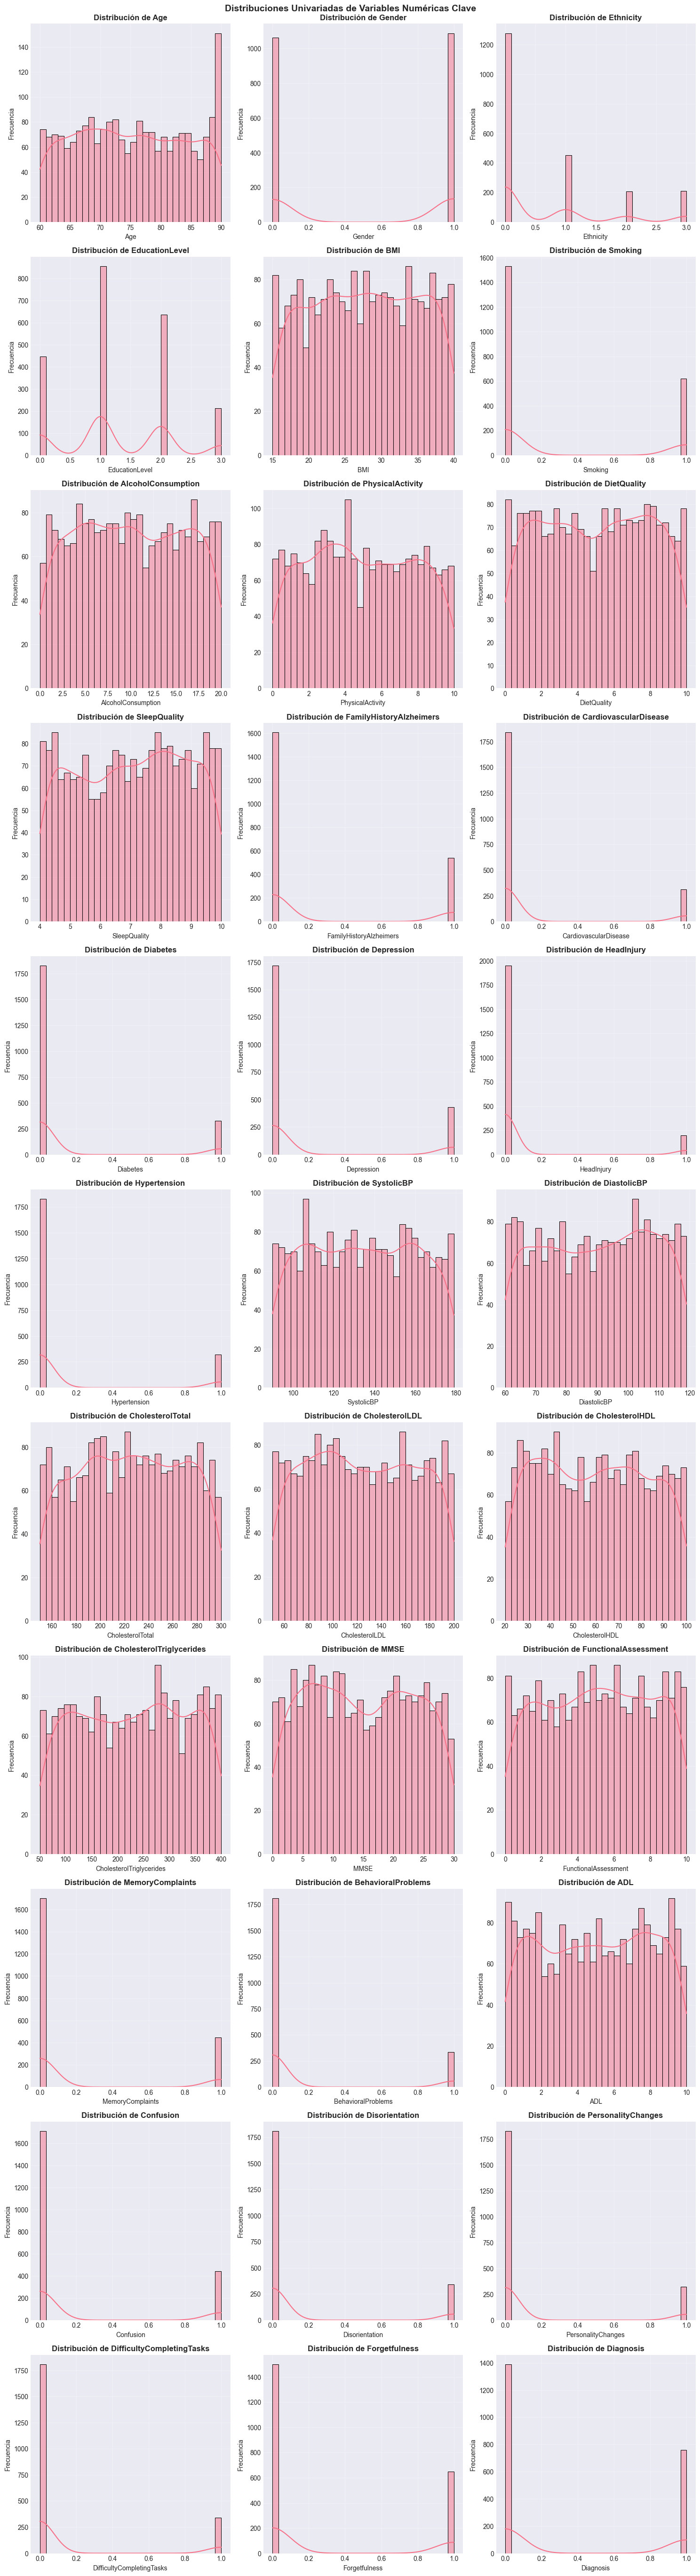

In [ ]:
if df is not None and numeric_vars:
    # Histogramas con KDE
    n_vars = len(numeric_vars)
    n_cols = 3
    n_rows = (n_vars + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_vars == 1 else axes
    
    for i, var in enumerate(numeric_vars):
        if i < len(axes):
            sns.histplot(df[var].dropna(), kde=True, ax=axes[i], bins=30)
            axes[i].set_title(f'Distribución de {var}', fontweight='bold')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Frecuencia')
            axes[i].grid(alpha=0.3)
    
    # Ocultar ejes vacíos
    for i in range(len(numeric_vars), len(axes)):
        axes[i].axis('off')
    
    plt.suptitle(f'Distribuciones Univariadas de TODAS las Variables Numéricas ({len(numeric_vars)} variables)', 
                 fontsize=14, fontweight='bold', y=0.995)
    plt.tight_layout()
    plt.show()


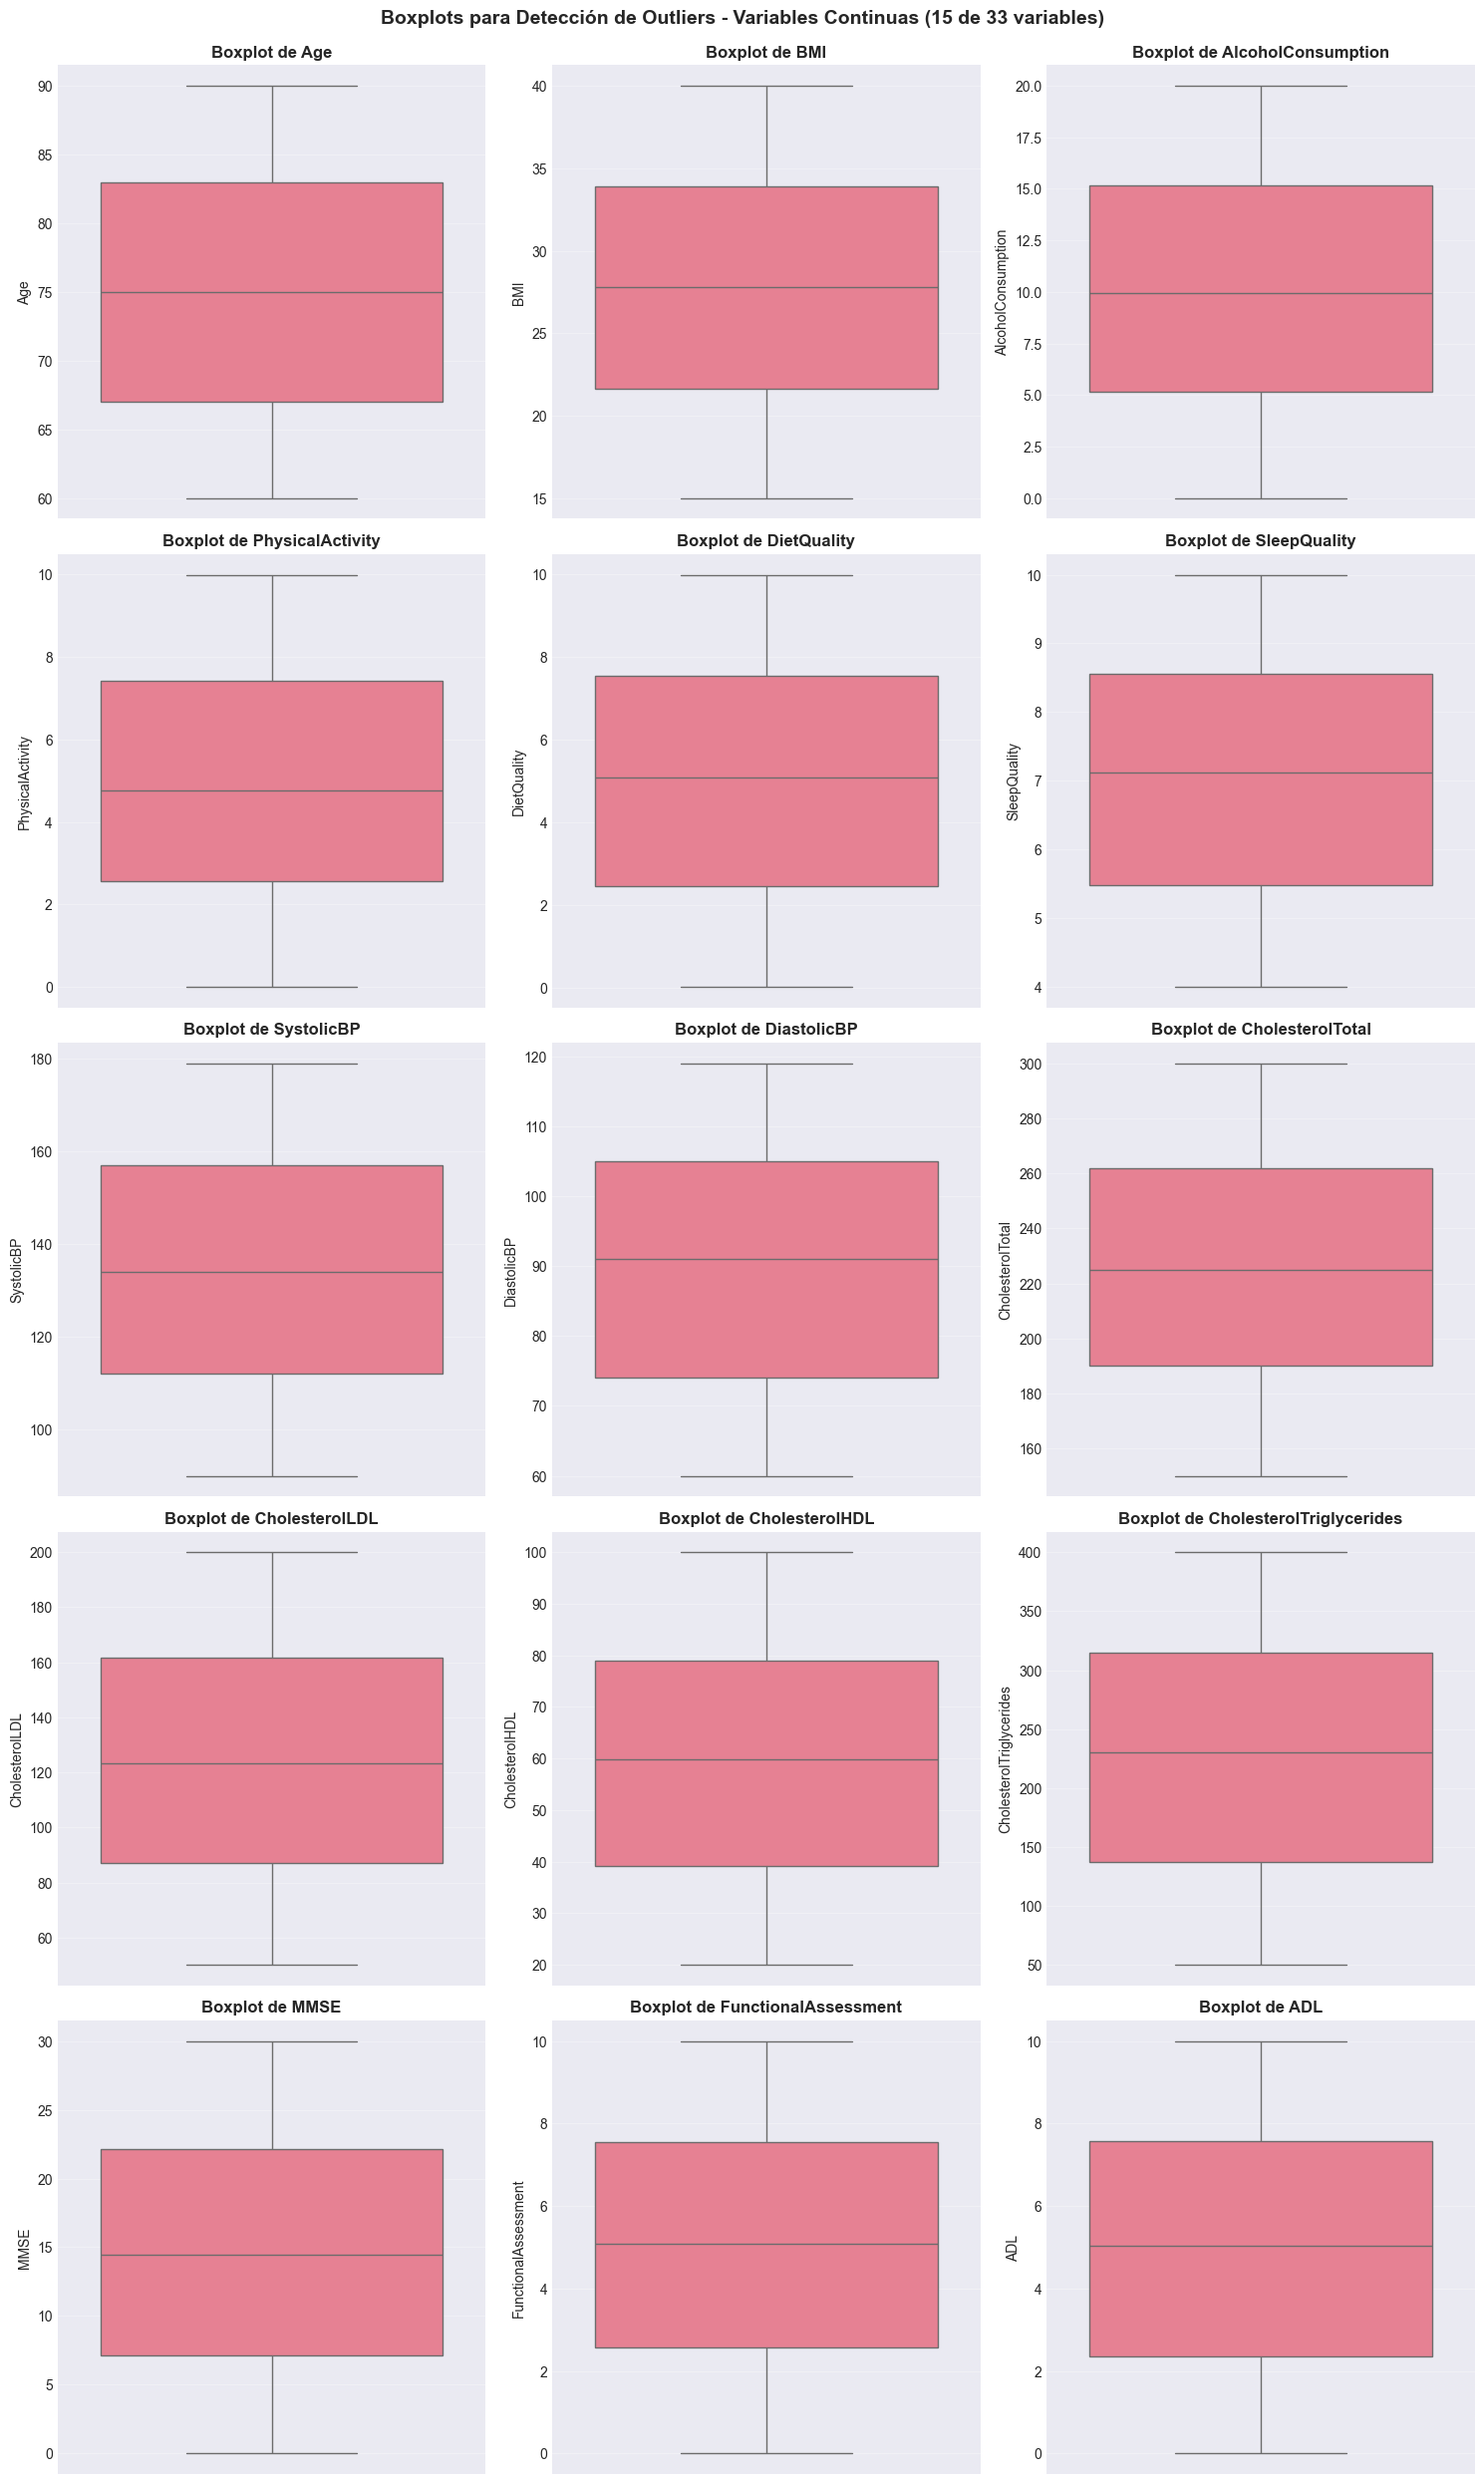


📊 Nota: Se muestran solo 15 variables continuas (excluyendo 18 variables discretas/binarias)


In [43]:
if df is not None and numeric_vars:
    # Filtrar solo variables continuas para boxplots (excluir discretas/binarias)
    # Las variables discretas no tienen sentido en boxplots
    continuous_vars_for_boxplot = []
    for var in numeric_vars:
        if var in df.columns:
            n_unique = df[var].nunique()
            # Considerar continua si tiene más de 10 valores únicos
            if n_unique > 10:
                continuous_vars_for_boxplot.append(var)
    
    if continuous_vars_for_boxplot:
        n_vars = len(continuous_vars_for_boxplot)
        n_cols = 3
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_vars == 1 else axes
        
        for i, var in enumerate(continuous_vars_for_boxplot):
            if i < len(axes):
                sns.boxplot(y=df[var].dropna(), ax=axes[i])
                axes[i].set_title(f'Boxplot de {var}', fontweight='bold')
                axes[i].set_ylabel(var)
                axes[i].grid(alpha=0.3, axis='y')
        
        # Ocultar ejes vacíos
        for i in range(len(continuous_vars_for_boxplot), len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f'Boxplots para Detección de Outliers - Variables Continuas ({len(continuous_vars_for_boxplot)} de {len(numeric_vars)} variables)', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Nota: Se muestran solo {len(continuous_vars_for_boxplot)} variables continuas (excluyendo {len(numeric_vars) - len(continuous_vars_for_boxplot)} variables discretas/binarias)")
    else:
        print("⚠️  No hay variables continuas para mostrar en boxplots")


### 🔍 Interpretación Esperada:

- **MMSE muy sesgado** → Posible desbalance cognitivo en la población
- **CDR** → Valores discretos (0, 0.5, 1, 2, 3) típicos de la escala
- **nWBV puede disminuir** → Con el deterioro cognitivo
- **Outliers** → Valores que pueden ser errores de medición o casos extremos


## 📌 2.2.3. Correlaciones (Heatmap)


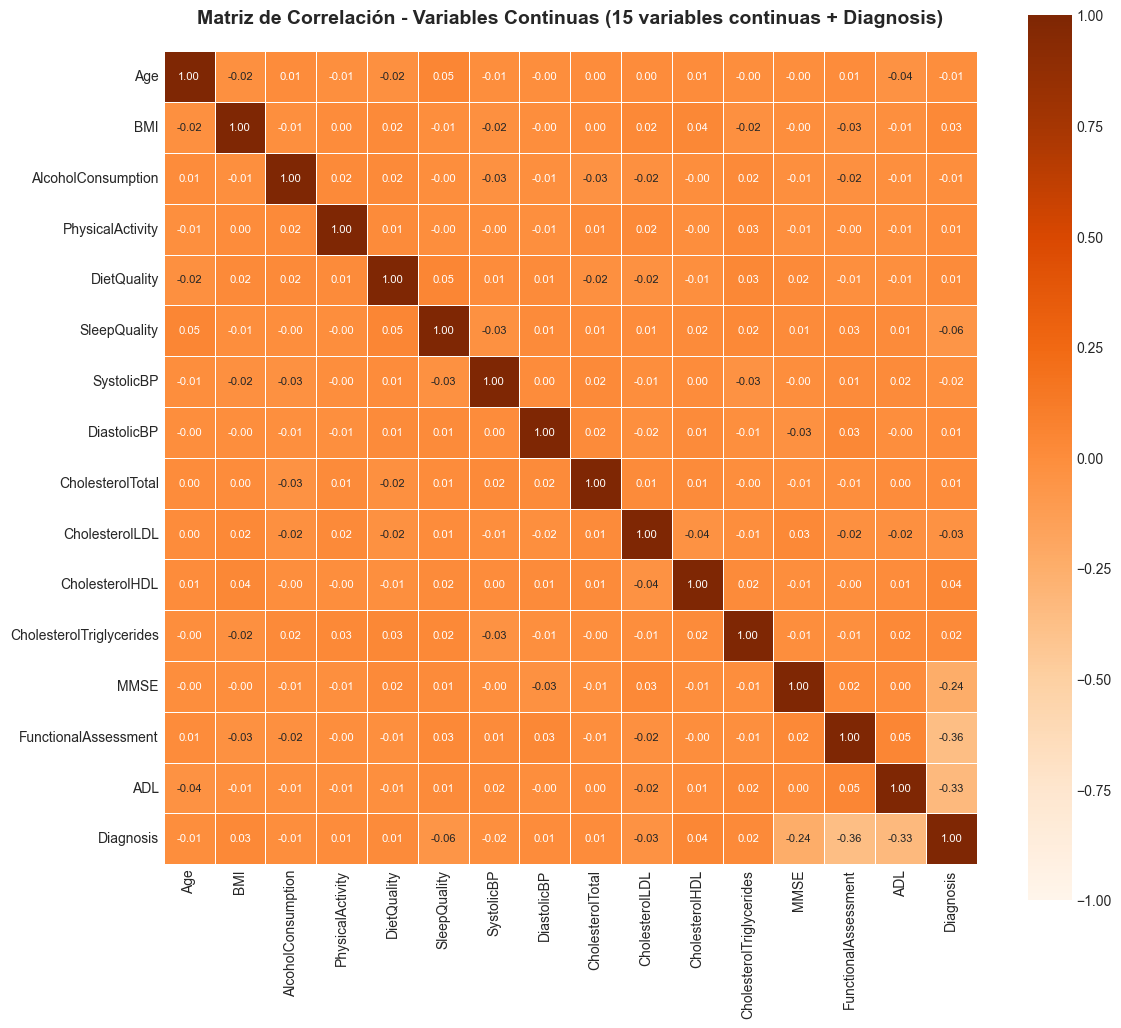


📊 Nota: Se muestran 15 variables continuas en la matriz de correlación
   (excluyendo 18 variables discretas/binarias)

📊 Correlaciones más fuertes con Diagnosis:
----------------------------------------------------------------------
FunctionalAssessment          :  -0.365 **
ADL                           :  -0.332 **
MMSE                          :  -0.237 *
SleepQuality                  :  -0.057 
CholesterolHDL                :   0.043 
CholesterolLDL                :  -0.032 
BMI                           :   0.026 
CholesterolTriglycerides      :   0.023 
SystolicBP                    :  -0.016 
DietQuality                   :   0.009 
AlcoholConsumption            :  -0.008 
CholesterolTotal              :   0.006 
PhysicalActivity              :   0.006 
Age                           :  -0.005 
DiastolicBP                   :   0.005 

Leyenda: *** |r|>0.5, ** |r|>0.3, * |r|>0.1


In [48]:
if df is not None:
    # Filtrar solo variables continuas para correlación (excluir discretas/binarias)
    # Las correlaciones de Pearson tienen más sentido para variables continuas
    continuous_vars_for_corr = []
    for var in numeric_vars:
        if var in df.columns:
            n_unique = df[var].nunique()
            # Considerar continua si tiene más de 10 valores únicos
            if n_unique > 10:
                continuous_vars_for_corr.append(var)
    
    # Agregar Diagnosis si existe (aunque sea binaria, es la variable objetivo)
    if 'Diagnosis' in df.columns:
        corr_vars = continuous_vars_for_corr + ['Diagnosis']
    else:
        corr_vars = continuous_vars_for_corr
    
    corr_vars = [var for var in corr_vars if var in df.columns]
    
    if len(corr_vars) > 1:
        # Calcular matriz de correlación
        corr_matrix = df[corr_vars].corr()
        
        # Ajustar tamaño de la figura según el número de variables
        n_vars = len(corr_vars)
        fig_size = max(12, min(20, n_vars * 0.5))
        
        # Crear heatmap con seaborn (visualización completa)
        plt.figure(figsize=(fig_size, fig_size))
        
        # Ajustar tamaño de anotaciones según número de variables
        # Mostrar anotaciones solo si hay 20 o menos variables para evitar sobrecarga visual
        show_annot = n_vars <= 20
        
        # Usar seaborn.heatmap con paleta de colores naranja
        sns.heatmap(
            corr_matrix, 
            annot=show_annot, 
            fmt='.2f', 
            cmap='Oranges',
            center=0,
            square=True, 
            linewidths=0.5, 
            cbar_kws={"shrink": 0.8},
            vmin=-1, 
            vmax=1,
            annot_kws={'size': 8} if show_annot else {}
        )
        
        plt.title(f'Matriz de Correlación - Variables Continuas ({len(continuous_vars_for_corr)} variables continuas + Diagnosis)', 
                  fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        print(f"\n📊 Nota: Se muestran {len(continuous_vars_for_corr)} variables continuas en la matriz de correlación")
        print(f"   (excluyendo {len(numeric_vars) - len(continuous_vars_for_corr)} variables discretas/binarias)")
        
        # Mostrar correlaciones más fuertes con Diagnosis (si existe)
        if 'Diagnosis' in corr_matrix.columns:
            print("\n📊 Correlaciones más fuertes con Diagnosis:")
            print("-" * 70)
            diagnosis_corr = corr_matrix['Diagnosis'].drop('Diagnosis').abs().sort_values(ascending=False)
            
            # Mostrar top 15 correlaciones
            top_n = min(15, len(diagnosis_corr))
            for var, corr_val in diagnosis_corr.head(top_n).items():
                original_corr = corr_matrix.loc[var, 'Diagnosis']
                significance = "***" if abs(original_corr) > 0.5 else "**" if abs(original_corr) > 0.3 else "*" if abs(original_corr) > 0.1 else ""
                print(f"{var:30s}: {original_corr:7.3f} {significance}")
            
            print("\nLeyenda: *** |r|>0.5, ** |r|>0.3, * |r|>0.1")
    else:
        print("⚠️  No hay suficientes variables continuas para calcular correlaciones")


## 📌 2.2.3.1. Correlación Todas contra Todas (Continuas y Discretas)

**Objetivo:** Analizar relaciones entre todas las variables (continuas vs continuas, discretas vs continuas, y discretas vs discretas) usando métodos estadísticos apropiados.


📊 Análisis de Correlación: TODAS contra TODAS

Variables continuas: 15
Variables discretas: 18
Total de variables: 33

Variables continuas: Age, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, SystolicBP, DiastolicBP, CholesterolTotal, CholesterolLDL...
Variables discretas: Gender, Ethnicity, EducationLevel, Smoking, FamilyHistoryAlzheimers, CardiovascularDisease, Diabetes, Depression, HeadInjury, Hypertension, MemoryComplaints, BehavioralProblems, Confusion, Disorientation, PersonalityChanges, DifficultyCompletingTasks, Forgetfulness, Diagnosis

📈 Top 30 Correlaciones más fuertes (en valor absoluto):
--------------------------------------------------------------------------------
FunctionalAssessment      ↔ Diagnosis                :  -0.365 ** [Punto-biserial ] (p=0.0000) ✓
ADL                       ↔ Diagnosis                :  -0.332 ** [Punto-biserial ] (p=0.0000) ✓
MemoryComplaints          ↔ Diagnosis                :   0.307 ** [Spearman       ] (p=0.0000)

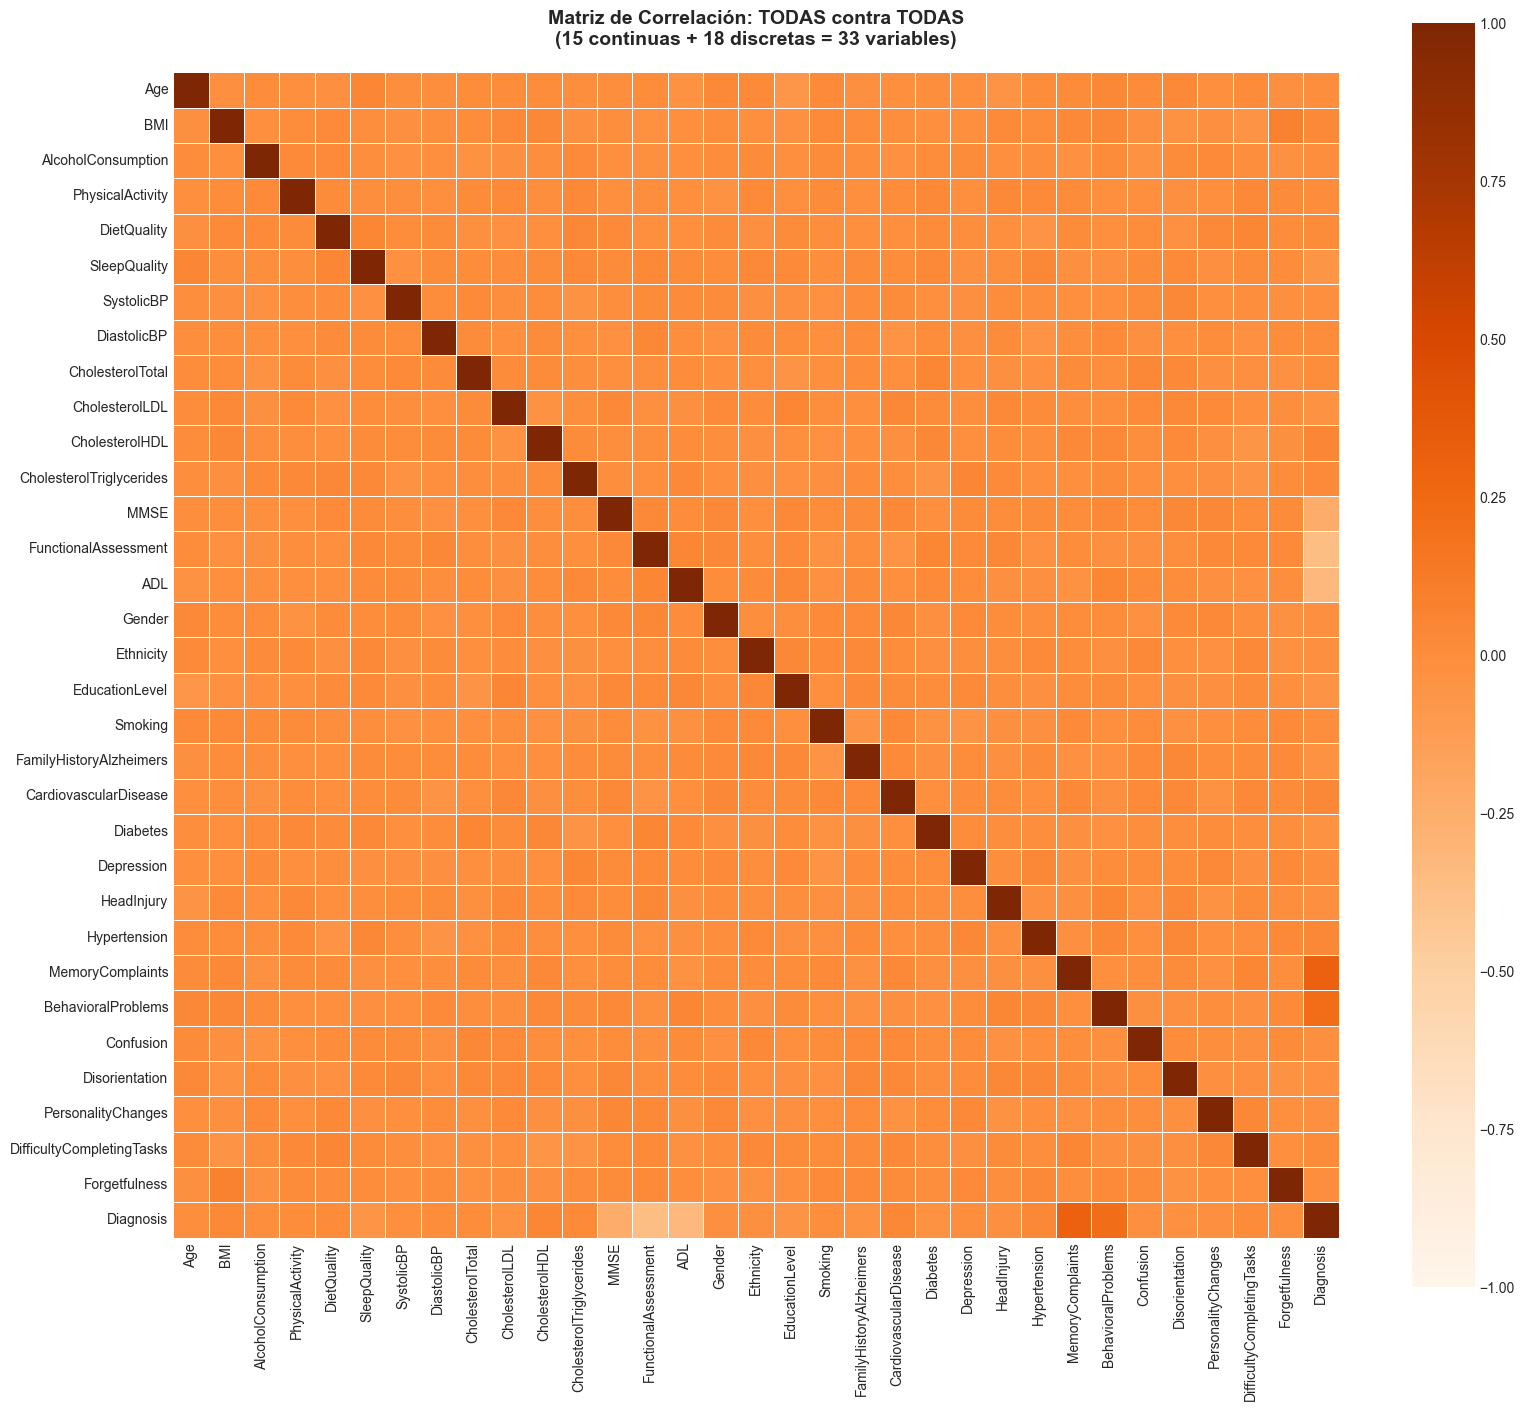


📊 Nota: Anotaciones ocultas para mejor legibilidad (33 variables)

📊 Correlaciones Significativas (p < 0.05):
Total de correlaciones significativas: 27


,Variable_1,Variable_2,Tipo_1,Tipo_2,Correlacion,p_value,Metodo
356,FunctionalAssessment,Diagnosis,Continua,Discreta,-0.364898,1.134785e-68,Punto-biserial
374,ADL,Diagnosis,Continua,Discreta,-0.332346,1.396884e-56,Punto-biserial
506,MemoryComplaints,Diagnosis,Discreta,Discreta,0.306742,4.760134e-48,Spearman
337,MMSE,Diagnosis,Continua,Discreta,-0.237126,7.537248e-29,Punto-biserial
512,BehavioralProblems,Diagnosis,Discreta,Discreta,0.224350,6.369488e-26,Spearman
61,BMI,Forgetfulness,Continua,Discreta,0.071131,9.678431e-04,Punto-biserial
16,Age,EducationLevel,Continua,Discreta,-0.064524,2.766859e-03,Spearman
294,CholesterolHDL,DifficultyCompletingTasks,Continua,Discreta,-0.056947,8.278226e-03,Punto-biserial
176,SleepQuality,Diagnosis,Continua,Discreta,-0.056548,8.741801e-03,Punto-biserial
338,FunctionalAssessment,ADL,Continua,Continua,0.053904,1.244672e-02,Pearson



📊 Resumen por Tipo de Correlación:
               Correlacion                       Significativo
                     count <lambda_0> <lambda_1>      <lambda>
Metodo                                                        
Pearson                105          0          0             3
Punto-biserial         240          2          0            16
Spearman               183          1          0             8


In [50]:
if df is not None:
    # Identificar variables discretas/binarias
    discrete_vars_for_analysis = []
    for var in numeric_vars:
        if var in df.columns:
            n_unique = df[var].nunique()
            # Considerar discreta si tiene 10 o menos valores únicos
            if n_unique <= 10:
                discrete_vars_for_analysis.append(var)
    
    # Variables continuas (ya identificadas anteriormente)
    continuous_vars_for_analysis = continuous_vars_for_corr.copy()
    
    # Combinar todas las variables para análisis completo
    all_vars_for_corr = continuous_vars_for_analysis + discrete_vars_for_analysis
    
    if len(all_vars_for_corr) > 1:
        print(f"📊 Análisis de Correlación: TODAS contra TODAS")
        print("=" * 70)
        print(f"\nVariables continuas: {len(continuous_vars_for_analysis)}")
        print(f"Variables discretas: {len(discrete_vars_for_analysis)}")
        print(f"Total de variables: {len(all_vars_for_corr)}")
        print(f"\nVariables continuas: {', '.join(continuous_vars_for_analysis[:10])}{'...' if len(continuous_vars_for_analysis) > 10 else ''}")
        print(f"Variables discretas: {', '.join(discrete_vars_for_analysis)}")
        
        # Crear matriz de correlaciones TODAS contra TODAS
        correlation_results = []
        
        # Calcular correlaciones para todos los pares de variables
        for i, var1 in enumerate(all_vars_for_corr):
            for var2 in all_vars_for_corr[i+1:]:  # Evitar duplicados (solo triangular superior)
                # Determinar tipo de correlación según los tipos de variables
                var1_is_continuous = var1 in continuous_vars_for_analysis
                var2_is_continuous = var2 in continuous_vars_for_analysis
                var1_is_binary = var1 in discrete_vars_for_analysis and df[var1].nunique() == 2
                var2_is_binary = var2 in discrete_vars_for_analysis and df[var2].nunique() == 2
                
                # Seleccionar método apropiado
                if var1_is_continuous and var2_is_continuous:
                    # Pearson para continuas vs continuas
                    corr_coef, p_value = stats.pearsonr(df[var1].dropna(), df[var2].dropna())
                    method = "Pearson"
                elif (var1_is_continuous and var2_is_binary) or (var1_is_binary and var2_is_continuous):
                    # Punto-biserial para continua vs binaria
                    corr_coef, p_value = stats.pearsonr(df[var1].dropna(), df[var2].dropna())
                    method = "Punto-biserial"
                else:
                    # Spearman para ordinal vs ordinal, ordinal vs continua, etc.
                    corr_coef, p_value = stats.spearmanr(df[var1].dropna(), df[var2].dropna())
                    method = "Spearman"
                
                correlation_results.append({
                    'Variable_1': var1,
                    'Variable_2': var2,
                    'Tipo_1': 'Continua' if var1_is_continuous else 'Discreta',
                    'Tipo_2': 'Continua' if var2_is_continuous else 'Discreta',
                    'Correlacion': corr_coef,
                    'p_value': p_value,
                    'Metodo': method,
                    'Significativo': 'Sí' if p_value < 0.05 else 'No'
                })
        
        # Crear DataFrame con resultados
        corr_all_df = pd.DataFrame(correlation_results)
        
        # Mostrar las correlaciones más fuertes
        print("\n📈 Top 30 Correlaciones más fuertes (en valor absoluto):")
        print("-" * 80)
        top_correlations = corr_all_df.reindex(
            corr_all_df['Correlacion'].abs().sort_values(ascending=False).index
        ).head(30)
        
        for idx, row in top_correlations.iterrows():
            significance = "***" if abs(row['Correlacion']) > 0.5 else "**" if abs(row['Correlacion']) > 0.3 else "*" if abs(row['Correlacion']) > 0.1 else ""
            sig_marker = "✓" if row['Significativo'] == 'Sí' else ""
            print(f"{row['Variable_1']:25s} ↔ {row['Variable_2']:25s}: "
                  f"{row['Correlacion']:7.3f} {significance} [{row['Metodo']:15s}] (p={row['p_value']:.4f}) {sig_marker}")
        
        print("\nLeyenda: *** |r|>0.5, ** |r|>0.3, * |r|>0.1, ✓ p<0.05")
        
        # Crear matriz completa de correlaciones para visualización
        # Construir matriz simétrica
        corr_matrix_all = pd.DataFrame(
            index=all_vars_for_corr,
            columns=all_vars_for_corr
        )
        
        # Llenar diagonal con 1.0
        for var in all_vars_for_corr:
            corr_matrix_all.loc[var, var] = 1.0
        
        # Llenar con los valores calculados
        for _, row in corr_all_df.iterrows():
            corr_matrix_all.loc[row['Variable_1'], row['Variable_2']] = row['Correlacion']
            corr_matrix_all.loc[row['Variable_2'], row['Variable_1']] = row['Correlacion']  # Simétrica
        
        # Convertir a float
        corr_matrix_all = corr_matrix_all.astype(float)
        
        # Visualización: Heatmap completo todas contra todas
        n_all_vars = len(all_vars_for_corr)
        fig_size = max(14, min(24, n_all_vars * 0.5))
        
        plt.figure(figsize=(fig_size, fig_size))
        
        # Mostrar anotaciones solo si hay 25 o menos variables
        show_annot_all = n_all_vars <= 25
        
        sns.heatmap(
            corr_matrix_all,
            annot=show_annot_all,
            fmt='.2f',
            cmap='Oranges',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            vmin=-1,
            vmax=1,
            annot_kws={'size': 7} if show_annot_all else {}
        )
        
        plt.title(f'Matriz de Correlación: TODAS contra TODAS\n'
                 f'({len(continuous_vars_for_analysis)} continuas + {len(discrete_vars_for_analysis)} discretas = {n_all_vars} variables)',
                 fontsize=14, fontweight='bold', pad=20)
        plt.tight_layout()
        plt.show()
        
        if not show_annot_all:
            print(f"\n📊 Nota: Anotaciones ocultas para mejor legibilidad ({n_all_vars} variables)")
        
        # Mostrar tabla completa de correlaciones significativas
        print(f"\n📊 Correlaciones Significativas (p < 0.05):")
        print("=" * 80)
        sig_corr = corr_all_df[corr_all_df['Significativo'] == 'Sí'].sort_values(
            'Correlacion', key=abs, ascending=False
        )
        
        if len(sig_corr) > 0:
            print(f"Total de correlaciones significativas: {len(sig_corr)}")
            display(sig_corr[['Variable_1', 'Variable_2', 'Tipo_1', 'Tipo_2', 
                             'Correlacion', 'p_value', 'Metodo']].head(50))
        else:
            print("No se encontraron correlaciones significativas (p < 0.05)")
        
        # Resumen por tipo de correlación
        print(f"\n📊 Resumen por Tipo de Correlación:")
        print("=" * 80)
        summary = corr_all_df.groupby('Metodo').agg({
            'Correlacion': ['count', lambda x: (x.abs() > 0.3).sum(), lambda x: (x.abs() > 0.5).sum()],
            'Significativo': lambda x: (x == 'Sí').sum()
        }).round(2)
        print(summary)
    else:
        print("⚠️  No hay suficientes variables para el análisis todas contra todas")


### 🔍 Posibles Hallazgos:

- **CDR correlaciona negativamente con nWBV** → Volumen cerebral menor en casos más severos
- **MMSE correlaciona con edad e intracranial volume** → Factores relacionados con deterioro
- **EDUC correlaciona débilmente** → Educación puede ser factor protector

**TODO seleccionar features** de regresión.


### 📚 Explicación de Métodos Estadísticos

#### **t-test (Prueba t de Student)**
- **Uso**: Comparar las medias de **dos grupos** (ej: con vs sin Alzheimer)
- **Hipótesis**: 
  - H₀: No hay diferencia entre las medias de los dos grupos
  - H₁: Hay diferencia significativa entre las medias
- **Resultado**: 
  - **p-value < 0.05** → Rechazamos H₀, hay diferencia significativa
  - **p-value ≥ 0.05** → No rechazamos H₀, no hay evidencia de diferencia
- **Ejemplo**: ¿El MMSE promedio es diferente entre pacientes con y sin Alzheimer?

#### **ANOVA (Análisis de Varianza)**
- **Uso**: Comparar las medias de **tres o más grupos** (ej: diferentes niveles de educación, categorías de edad)
- **Hipótesis**:
  - H₀: Todas las medias de los grupos son iguales
  - H₁: Al menos una media es diferente
- **Resultado**:
  - **F-statistic**: Mide la razón entre varianza entre grupos y varianza dentro de grupos
  - **p-value < 0.05** → Rechazamos H₀, hay diferencias significativas entre al menos dos grupos
  - **p-value ≥ 0.05** → No rechazamos H₀, no hay evidencia de diferencias
- **Ejemplo**: ¿El MMSE promedio es diferente entre grupos de edad (Joven, Media, Mayor, Muy Mayor)?

#### **Interpretación Práctica**
- **t-test**: "¿Esta variable es diferente entre dos grupos específicos?"
- **ANOVA**: "¿Esta variable es diferente entre múltiples grupos/categorías?"
- Ambos métodos ayudan a identificar **predictores importantes** para modelos de regresión/clasificación


## 📌 2.2.4. Detección de Outliers

In [58]:
if df is not None and numeric_vars:
    # Detección de outliers usando Z-score
    print("\n🔍 Detección de Outliers usando Z-score (|Z| > 3):")
    print("=" * 70)
    
    outliers_summary = {}
    
    for var in numeric_vars:  # Analizar TODAS las variables numéricas
        if var in df.columns:
            data = df[var].dropna()
            if len(data) > 0:
                z_scores = np.abs(stats.zscore(data))
                outliers = np.sum(z_scores > 3)
                outliers_pct = (outliers / len(data)) * 100
                outliers_summary[var] = {'count': outliers, 'percentage': outliers_pct}
                
                if outliers > 0:
                    print(f"{var:30s}: {outliers:4d} outliers ({outliers_pct:5.2f}%)")
    
    # Detección usando IQR
    print("\n🔍 Detección de Outliers usando IQR (Q1-1.5*IQR, Q3+1.5*IQR):")
    print("=" * 70)
    
    for var in numeric_vars:  # Analizar TODAS las variables numéricas
        if var in df.columns:
            data = df[var].dropna()
            if len(data) > 0:
                Q1 = data.quantile(0.25)
                Q3 = data.quantile(0.75)
                IQR = Q3 - Q1
                lower_bound = Q1 - 1.5 * IQR
                upper_bound = Q3 + 1.5 * IQR
                
                outliers_iqr = ((data < lower_bound) | (data > upper_bound)).sum()
                outliers_iqr_pct = (outliers_iqr / len(data)) * 100
                
                if outliers_iqr > 0:
                    print(f"{var:30s}: {outliers_iqr:4d} outliers ({outliers_iqr_pct:5.2f}%)")
                    print(f"{'':30s}  Rango: [{lower_bound:.2f}, {upper_bound:.2f}]")
    
    print("\n⚠️  Si hay valores absurdos (ej. MMSE = 50), considerar descartarlos.")



🔍 Detección de Outliers usando Z-score (|Z| > 3):
HeadInjury                    :  199 outliers ( 9.26%)

🔍 Detección de Outliers usando IQR (Q1-1.5*IQR, Q3+1.5*IQR):
Ethnicity                     :  211 outliers ( 9.82%)
                                Rango: [-1.50, 2.50]
CardiovascularDisease         :  310 outliers (14.43%)
                                Rango: [0.00, 0.00]
Diabetes                      :  324 outliers (15.08%)
                                Rango: [0.00, 0.00]
Depression                    :  431 outliers (20.06%)
                                Rango: [0.00, 0.00]
HeadInjury                    :  199 outliers ( 9.26%)
                                Rango: [0.00, 0.00]
Hypertension                  :  320 outliers (14.89%)
                                Rango: [0.00, 0.00]
MemoryComplaints              :  447 outliers (20.80%)
                                Rango: [0.00, 0.00]
BehavioralProblems            :  337 outliers (15.68%)
                           

## 📌 2.2.5. Comparación entre Grupos (ANOVA / t-test)

## 📌 2.2.5.1. ANOVA Extendido - Todas las Variables Categóricas

**Objetivo:** Realizar ANOVA entre múltiples grupos usando todas las variables categóricas (existentes y categorizadas).


In [57]:
# ANOVA entre múltiples grupos - Análisis completo
# Incluye variables categóricas y variables continuas categorizadas
if df is not None:
    print("\n📊 ANOVA entre Múltiples Grupos (Análisis Extendido):")
    print("=" * 70)
    
    # Crear copia del dataframe para categorizar variables continuas
    df_anova = df.copy()
    
    # 1. Variables categóricas/discretas existentes
    categorical_vars = []
    
    # Variables discretas que ya existen
    discrete_categorical = ['Ethnicity', 'EducationLevel', 'Gender', 'Smoking', 
                          'FamilyHistoryAlzheimers', 'CardiovascularDisease', 
                          'Diabetes', 'Depression', 'HeadInjury', 'Hypertension',
                          'MemoryComplaints', 'BehavioralProblems', 'Confusion']
    
    for var in discrete_categorical:
        if var in df.columns:
            n_unique = df[var].nunique()
            if n_unique <= 10:  # Variables con pocos valores únicos
                categorical_vars.append(var)
    
    # 2. Categorizar variables continuas para crear grupos
    
    # Edad: Joven (<65), Media (65-75), Mayor (75-85), Muy Mayor (>85)
    if 'Age' in df.columns:
        df_anova['Age_Category'] = pd.cut(df['Age'], 
                                          bins=[0, 65, 75, 85, 120], 
                                          labels=['Joven (<65)', 'Media (65-75)', 'Mayor (75-85)', 'Muy Mayor (>85)'])
        categorical_vars.append('Age_Category')
    
    # BMI: Bajo (<18.5), Normal (18.5-25), Alto (25-30), Muy Alto (>30)
    if 'BMI' in df.columns:
        df_anova['BMI_Category'] = pd.cut(df['BMI'], 
                                          bins=[0, 18.5, 25, 30, 100], 
                                          labels=['Bajo (<18.5)', 'Normal (18.5-25)', 'Alto (25-30)', 'Muy Alto (>30)'])
        categorical_vars.append('BMI_Category')
    
    # Colesterol Total: Bajo (<200), Normal (200-240), Alto (>240)
    if 'CholesterolTotal' in df.columns:
        df_anova['Cholesterol_Category'] = pd.cut(df['CholesterolTotal'], 
                                                   bins=[0, 200, 240, 1000], 
                                                   labels=['Bajo (<200)', 'Normal (200-240)', 'Alto (>240)'])
        categorical_vars.append('Cholesterol_Category')
    
    # Colesterol LDL: Óptimo (<100), Normal (100-130), Alto (130-160), Muy Alto (>160)
    if 'CholesterolLDL' in df.columns:
        df_anova['LDL_Category'] = pd.cut(df['CholesterolLDL'], 
                                          bins=[0, 100, 130, 160, 1000], 
                                          labels=['Óptimo (<100)', 'Normal (100-130)', 'Alto (130-160)', 'Muy Alto (>160)'])
        categorical_vars.append('LDL_Category')
    
    # Presión Arterial Sistólica: Normal (<120), Elevada (120-130), Alta (130-140), Muy Alta (>140)
    if 'SystolicBP' in df.columns:
        df_anova['SystolicBP_Category'] = pd.cut(df['SystolicBP'], 
                                                 bins=[0, 120, 130, 140, 300], 
                                                 labels=['Normal (<120)', 'Elevada (120-130)', 'Alta (130-140)', 'Muy Alta (>140)'])
        categorical_vars.append('SystolicBP_Category')
    
    # MMSE: Normal (≥24), Deterioro Leve (18-23), Deterioro Moderado (10-17), Deterioro Severo (<10)
    if 'MMSE' in df.columns:
        df_anova['MMSE_Category'] = pd.cut(df['MMSE'], 
                                         bins=[0, 10, 17, 23, 31], 
                                         labels=['Severo (<10)', 'Moderado (10-17)', 'Leve (18-23)', 'Normal (≥24)'])
        categorical_vars.append('MMSE_Category')
    
    print(f"\n📋 Variables categóricas identificadas: {len(categorical_vars)}")
    print(f"Variables: {', '.join(categorical_vars[:10])}{'...' if len(categorical_vars) > 10 else ''}")
    
    # Variables numéricas continuas para comparar
    continuous_vars_for_anova = continuous_vars_for_corr.copy()
    
    # Agregar variables importantes si no están ya incluidas
    important_vars = ['MMSE', 'ADL', 'FunctionalAssessment', 'Age', 'BMI']
    for var in important_vars:
        if var in df.columns and var not in continuous_vars_for_anova:
            continuous_vars_for_anova.append(var)
    
    print(f"\n📊 Variables numéricas a comparar: {len(continuous_vars_for_anova)}")
    print(f"Variables: {', '.join(continuous_vars_for_anova[:10])}{'...' if len(continuous_vars_for_anova) > 10 else ''}")
    
    # Realizar ANOVA para cada combinación de variable categórica vs continua
    anova_results = []
    
    for cat_var in categorical_vars:
        if cat_var in df_anova.columns:
            # Obtener grupos únicos
            unique_groups = df_anova[cat_var].dropna().unique()
            
            if len(unique_groups) > 1:  # Necesitamos al menos 2 grupos
                for cont_var in continuous_vars_for_anova:
                    if cont_var in df_anova.columns:
                        # Preparar grupos para ANOVA
                        groups = []
                        group_labels = []
                        group_sizes = []
                        
                        for group_val in sorted(unique_groups):
                            group_data = df_anova[df_anova[cat_var] == group_val][cont_var].dropna()
                            if len(group_data) >= 3:  # Mínimo 3 observaciones por grupo
                                groups.append(group_data)
                                group_labels.append(str(group_val))
                                group_sizes.append(len(group_data))
                        
                        if len(groups) >= 2:  # Al menos 2 grupos válidos
                            try:
                                # Realizar ANOVA
                                f_stat, p_value = stats.f_oneway(*groups)
                                
                                # Calcular medias por grupo
                                group_means = [g.mean() for g in groups]
                                
                                anova_results.append({
                                    'Variable_Categorica': cat_var,
                                    'Variable_Numerica': cont_var,
                                    'Num_Grupos': len(groups),
                                    'F_statistic': f_stat,
                                    'p_value': p_value,
                                    'Significativo': 'Sí' if p_value < 0.05 else 'No',
                                    'Medias_Grupos': ', '.join([f"{label}: {mean:.2f}" for label, mean in zip(group_labels, group_means)]),
                                    'Tamaños_Grupos': ', '.join([f"{label}: {size}" for label, size in zip(group_labels, group_sizes)])
                                })
                            except Exception as e:
                                # Si hay error en ANOVA, continuar con la siguiente
                                continue
    
    # Crear DataFrame con resultados
    if anova_results:
        anova_df = pd.DataFrame(anova_results)
        
        # Mostrar resumen
        print(f"\n📊 Resumen de Análisis ANOVA:")
        print("=" * 70)
        print(f"Total de comparaciones realizadas: {len(anova_df)}")
        print(f"Comparaciones significativas (p < 0.05): {len(anova_df[anova_df['Significativo'] == 'Sí'])}")
        
        # Mostrar las comparaciones más significativas
        print(f"\n📈 Top 20 Comparaciones más Significativas (menor p-value):")
        print("=" * 70)
        top_anova = anova_df.nsmallest(20, 'p_value')
        
        for idx, row in top_anova.iterrows():
            sig_marker = "✅" if row['Significativo'] == 'Sí' else "❌"
            print(f"\n{sig_marker} {row['Variable_Categorica']:25s} → {row['Variable_Numerica']:25s}")
            print(f"   F-statistic: {row['F_statistic']:8.4f}, p-value: {row['p_value']:.6f}")
            print(f"   Grupos ({row['Num_Grupos']}): {row['Medias_Grupos']}")
            print(f"   Tamaños: {row['Tamaños_Grupos']}")
        
        # Mostrar todas las comparaciones significativas en tabla
        print(f"\n📊 Todas las Comparaciones Significativas (p < 0.05):")
        print("=" * 70)
        sig_anova = anova_df[anova_df['Significativo'] == 'Sí'].sort_values('p_value')
        
        if len(sig_anova) > 0:
            display(sig_anova[['Variable_Categorica', 'Variable_Numerica', 'Num_Grupos', 
                              'F_statistic', 'p_value', 'Medias_Grupos']].head(50))
        else:
            print("No se encontraron diferencias significativas (p < 0.05)")
        
        # Resumen por variable categórica
        print(f"\n📊 Resumen por Variable Categórica:")
        print("=" * 70)
        summary_by_cat = anova_df.groupby('Variable_Categorica').agg({
            'p_value': 'count',
            'Significativo': lambda x: (x == 'Sí').sum()
        }).rename(columns={'p_value': 'Total_Comparaciones', 'Significativo': 'Significativas'})
        summary_by_cat['Porcentaje_Sig'] = (summary_by_cat['Significativas'] / summary_by_cat['Total_Comparaciones'] * 100).round(1)
        print(summary_by_cat.sort_values('Significativas', ascending=False))
    else:
        print("⚠️  No se pudieron realizar comparaciones ANOVA")



📊 ANOVA entre Múltiples Grupos (Análisis Extendido):

📋 Variables categóricas identificadas: 19
Variables: Ethnicity, EducationLevel, Gender, Smoking, FamilyHistoryAlzheimers, CardiovascularDisease, Diabetes, Depression, HeadInjury, Hypertension...

📊 Variables numéricas a comparar: 15
Variables: Age, BMI, AlcoholConsumption, PhysicalActivity, DietQuality, SleepQuality, SystolicBP, DiastolicBP, CholesterolTotal, CholesterolLDL...

📊 Resumen de Análisis ANOVA:
Total de comparaciones realizadas: 285
Comparaciones significativas (p < 0.05): 20

📈 Top 20 Comparaciones más Significativas (menor p-value):

✅ Age_Category              → Age                      
   F-statistic: 8667.0584, p-value: 0.000000
   Grupos (4): Joven (<65): 62.40, Mayor (75-85): 80.35, Media (65-75): 70.32, Muy Mayor (>85): 88.18
   Tamaños: Joven (<65): 404, Mayor (75-85): 674, Media (65-75): 718, Muy Mayor (>85): 353

✅ BMI_Category              → BMI                      
   F-statistic: 6978.6888, p-value: 0.00

,Variable_Categorica,Variable_Numerica,Num_Grupos,F_statistic,p_value,Medias_Grupos
233,Cholesterol_Category,CholesterolTotal,3,7547.145404,0.000000,"Alto (>240): 269.48, Bajo (<200): 175.57, Norm..."
249,LDL_Category,CholesterolLDL,4,9044.789605,0.000000,"Alto (130-160): 145.69, Muy Alto (>160): 180.2..."
211,BMI_Category,BMI,4,6978.688849,0.000000,"Alto (25-30): 27.53, Bajo (<18.5): 16.75, Muy ..."
195,Age_Category,Age,4,8667.058355,0.000000,"Joven (<65): 62.40, Mayor (75-85): 80.35, Medi..."
282,MMSE_Category,MMSE,4,9602.395567,0.000000,"Leve (18-23): 20.06, Moderado (10-17): 13.26, ..."
261,SystolicBP_Category,SystolicBP,4,5096.663827,0.000000,"Alta (130-140): 135.63, Elevada (120-130): 125..."
242,LDL_Category,AlcoholConsumption,4,4.615765,0.003181,"Alto (130-160): 10.85, Muy Alto (>160): 9.47, ..."
15,EducationLevel,Age,4,3.610934,0.012810,"0: 75.79, 1: 75.15, 2: 74.06, 3: 74.62"
247,LDL_Category,DiastolicBP,4,3.430475,0.016411,"Alto (130-160): 91.34, Muy Alto (>160): 88.09,..."
98,Diabetes,CholesterolTotal,2,5.118176,0.023776,"0: 224.32, 1: 230.12"



📊 Resumen por Variable Categórica:
                         Total_Comparaciones  Significativas  Porcentaje_Sig
Variable_Categorica                                                         
SystolicBP_Category                       15               3            20.0
LDL_Category                              15               3            20.0
Diabetes                                  15               3            20.0
Age_Category                              15               2            13.3
Hypertension                              15               2            13.3
BehavioralProblems                        15               1             6.7
BMI_Category                              15               1             6.7
EducationLevel                            15               1             6.7
CardiovascularDisease                     15               1             6.7
Depression                                15               1             6.7
Cholesterol_Category                    


📊 Comparación entre Grupos (Diagnosis: 0=Sin Alzheimer, 1=Con Alzheimer)

📊 Resumen de Comparaciones (Total: 32 variables):


,Variable,Media (Sin Alzheimer),Media (Con Alzheimer),Diferencia,t-statistic,p-value,Significativo (p<0.05)
0,Age,74.945284,74.842105,-0.103179,0.254312,7.992790e-01,No
1,Gender,0.514039,0.492105,-0.021934,0.972092,3.311141e-01,No
2,Ethnicity,0.708423,0.677632,-0.030792,0.685023,4.934032e-01,No
3,EducationLevel,1.316055,1.232895,-0.083160,2.039162,4.155613e-02,Sí
4,BMI,27.515092,27.912670,0.397578,-1.221037,2.222060e-01,No
5,Smoking,0.290137,0.285526,-0.004610,0.225437,8.216609e-01,No
6,AlcoholConsumption,10.071880,9.980156,-0.091724,0.352994,7.241273e-01,No
7,PhysicalActivity,4.907640,4.943160,0.035520,-0.275473,7.829796e-01,No
8,DietQuality,4.974839,5.026581,0.051742,-0.394135,6.935202e-01,No
9,SleepQuality,7.124832,6.916292,-0.208540,2.624396,8.741801e-03,Sí



📈 Visualizando 8 variables (de 32 analizadas)


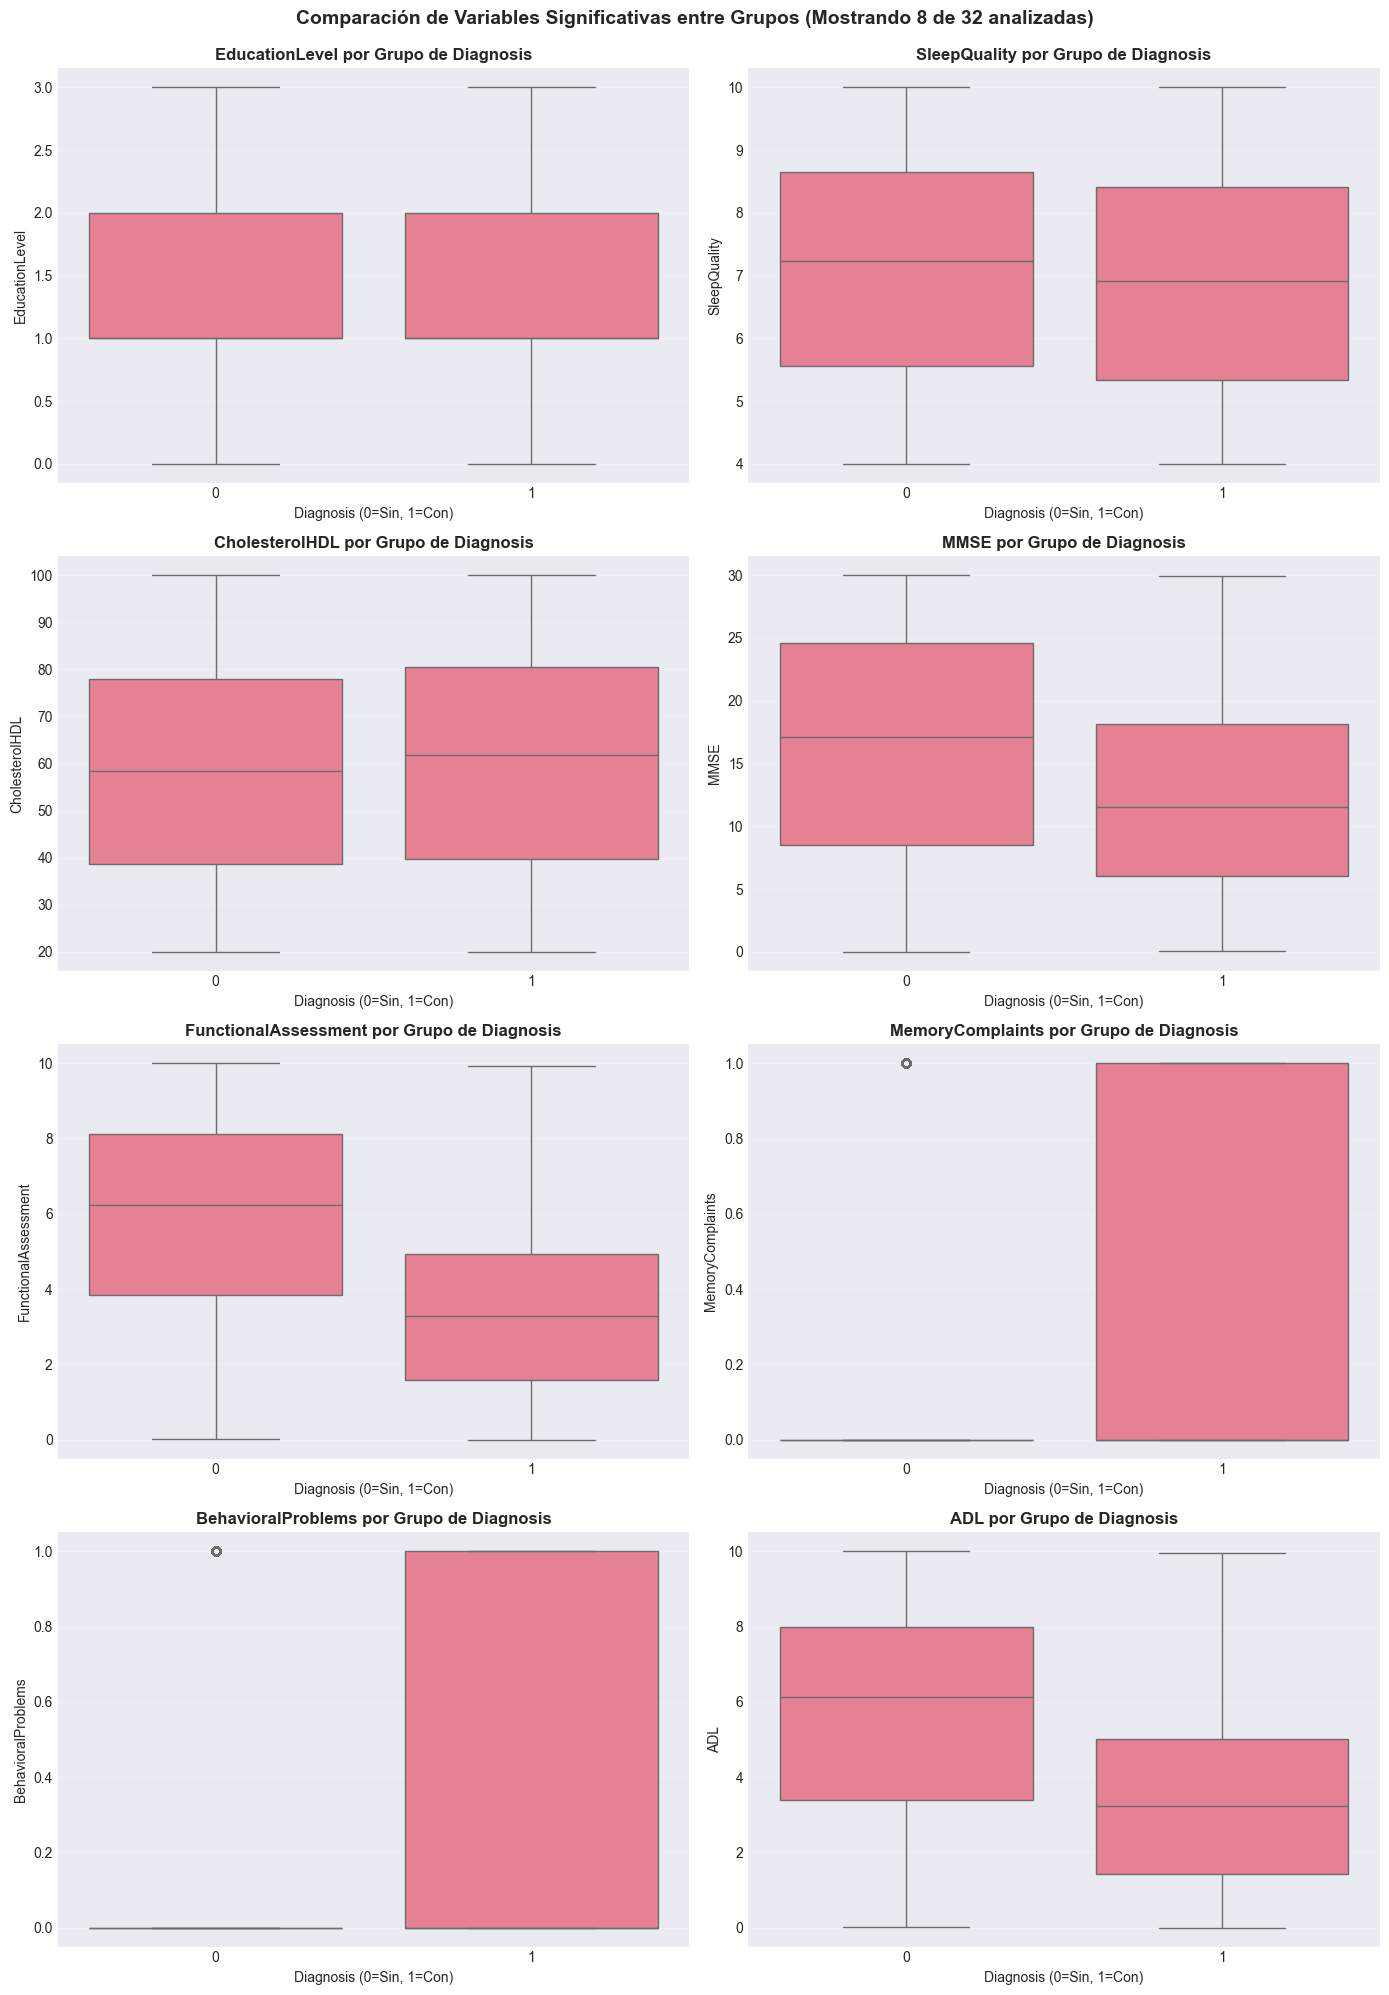

In [59]:
if df is not None and 'Diagnosis' in df.columns:
    # Comparar variables numéricas entre grupos de Diagnosis
    print("\n📊 Comparación entre Grupos (Diagnosis: 0=Sin Alzheimer, 1=Con Alzheimer)")
    print("=" * 70)
    
    # Comparar TODAS las variables numéricas entre grupos
    # Excluir Diagnosis ya que es la variable objetivo
    comparison_vars = [var for var in numeric_vars if var != 'Diagnosis' and var in df.columns]
    
    results = []
    
    for var in comparison_vars:
        group_0 = df[df['Diagnosis'] == 0][var].dropna()
        group_1 = df[df['Diagnosis'] == 1][var].dropna()
        
        if len(group_0) > 0 and len(group_1) > 0:
            # t-test
            t_stat, p_value = stats.ttest_ind(group_0, group_1)
            
            mean_0 = group_0.mean()
            mean_1 = group_1.mean()
            
            results.append({
                'Variable': var,
                'Media (Sin Alzheimer)': mean_0,
                'Media (Con Alzheimer)': mean_1,
                'Diferencia': mean_1 - mean_0,
                't-statistic': t_stat,
                'p-value': p_value,
                'Significativo (p<0.05)': 'Sí' if p_value < 0.05 else 'No'
            })
    
    results_df = pd.DataFrame(results)
    
    # Mostrar todas las comparaciones en la tabla
    print(f"\n📊 Resumen de Comparaciones (Total: {len(results_df)} variables):")
    print("=" * 70)
    display(results_df)
    
    # Mostrar solo las variables más significativas en la visualización (p < 0.05)
    # pero el análisis completo está en la tabla arriba
    significant_vars = results_df[results_df['p-value'] < 0.05]['Variable'].tolist()
    
    # Si hay muchas variables significativas, mostrar las top 20
    if len(significant_vars) > 20:
        # Ordenar por p-value y tomar las top 20
        sig_df = results_df[results_df['p-value'] < 0.05].sort_values('p-value').head(20)
        vars_to_plot = sig_df['Variable'].tolist()
        print(f"\n📈 Visualizando las 20 variables más significativas (de {len(significant_vars)} significativas)")
    else:
        vars_to_plot = significant_vars if significant_vars else comparison_vars[:20]
        if len(vars_to_plot) < len(comparison_vars):
            print(f"\n📈 Visualizando {len(vars_to_plot)} variables (de {len(comparison_vars)} analizadas)")
    
    # Visualización de comparación
    if vars_to_plot:
        n_vars = len(vars_to_plot)
        n_cols = 2
        n_rows = (n_vars + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5*n_rows))
        axes = axes.flatten() if n_rows > 1 else [axes] if n_vars == 1 else axes
        
        for i, var in enumerate(vars_to_plot):
            if i < len(axes):
                sns.boxplot(data=df, x='Diagnosis', y=var, ax=axes[i])
                axes[i].set_title(f'{var} por Grupo de Diagnosis', fontweight='bold')
                axes[i].set_xlabel('Diagnosis (0=Sin, 1=Con)')
                axes[i].set_ylabel(var)
                axes[i].grid(alpha=0.3, axis='y')
        
        # Ocultar ejes vacíos
        for i in range(len(vars_to_plot), len(axes)):
            axes[i].axis('off')
        
        plt.suptitle(f'Comparación de Variables Significativas entre Grupos (Mostrando {len(vars_to_plot)} de {len(comparison_vars)} analizadas)', 
                     fontsize=14, fontweight='bold', y=0.995)
        plt.tight_layout()
        plt.show()
    else:
        print("\n⚠️  No hay variables significativas para visualizar (p < 0.05)")


### 🔍 Interpretación:

- **p-value < 0.05** → Diferencias significativas entre grupos clínicos
- Esto prepara la base para **modelos de regresión**
- Variables con diferencias significativas son buenos predictores


---
# 📝 CONCLUSIÓN DEL EDA

## TODO Resumen de Hallazgos

### ✅ Calidad del Dataset

- [ ] **Imágenes**: Calidad general, presencia de ruido/artefactos
- [ ] **Datos clínicos**: Completitud, valores faltantes
- [ ] **Consistencia**: Coherencia entre diferentes fuentes de datos

### ⚖️ Desbalances Encontrados

- [ ] **Clases de imágenes**: Desbalance entre NonDemented, VeryMildDemented, MildDemented, ModerateDemented
- [ ] **Datos clínicos**: Distribución de Diagnosis (0 vs 1)
- [ ] **Estrategias sugeridas**: Oversampling, undersampling, class weights

### 🎯 Variables Útiles para Regresión

- [ ] **Variables con alta correlación con Diagnosis**:
  - [ ] Variable 1
  - [ ] Variable 2
  - [ ] Variable 3

- [ ] **Variables con diferencias significativas entre grupos**:
  - [ ] Variable 1
  - [ ] Variable 2

### 👁️ Señales Visuales en MRIs

- [ ] **Diferencias observables**: ¿Hay diferencias visuales evidentes entre clases?
- [ ] **Patrones anatómicos**: ¿Se pueden identificar patrones distintivos?
- [ ] **Calidad de imágenes**: ¿Necesitan preprocesamiento adicional?

### ⚠️ Limitaciones Iniciales

- [ ] **Tamaño de muestra**: ¿Es suficiente para entrenar modelos robustos?
- [ ] **Desbalance de clases**: ¿Afectará el rendimiento de los modelos?
- [ ] **Calidad de datos**: ¿Hay datos faltantes o corruptos que necesiten atención?
- [ ] **Sesgos**: ¿Hay sesgos demográficos o de selección que deban considerarse?

### 🚀 Próximos Pasos

1. **Preprocesamiento**: Aplicar las correcciones identificadas
2. **Feature Engineering**: Crear características adicionales basadas en hallazgos
3. **Modelado**: Proceder con entrenamiento de modelos (H1, H2, H3)
4. **Validación**: Usar las divisiones train/val/test establecidas
